# Suppress ALL output for cleaner notebook
import warnings
import logging
import os
import sys
from contextlib import redirect_stdout, redirect_stderr
from io import StringIO

# Comprehensive warning and output suppression
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set root logger to CRITICAL to suppress all INFO messages
logging.getLogger().setLevel(logging.CRITICAL)
logging.basicConfig(level=logging.CRITICAL)

# Suppress stdout/stderr for imports
old_stdout = sys.stdout
old_stderr = sys.stderr
sys.stdout = StringIO()
sys.stderr = StringIO()

try:
    # Pre-import mealpy to suppress its initialization messages
    import mealpy
    from mealpy.bio_based import SMA
    # Disable mealpy logging after import
    mealpy_logger = logging.getLogger('mealpy')
    mealpy_logger.setLevel(logging.CRITICAL)
    mealpy_logger.disabled = True
except:
    pass

# Restore stdout/stderr
sys.stdout = old_stdout
sys.stderr = old_stderr

print("🔇 Output suppression activated for clean notebook execution")

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import seaborn as sns
import warnings
import logging

# Additional suppression for mealpy logging
def suppress_mealpy_logging():
    """Comprehensively suppress mealpy logging output"""
    # Disable all mealpy loggers
    for name in logging.root.manager.loggerDict:
        if 'mealpy' in name:
            logger = logging.getLogger(name)
            logger.setLevel(logging.CRITICAL)
            logger.disabled = True
    
    # Also disable the root logger during optimization
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.CRITICAL)

# CoFI imports
from cofi import BaseProblem, InversionOptions, Inversion

# Set style for beautiful plots
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🧬 Welcome to the Slime Mould Algorithm Demo!")
print("📊 Imports successful - ready to explore bio-inspired optimization")

🧬 Welcome to the Slime Mould Algorithm Demo!
📊 Imports successful - ready to explore bio-inspired optimization


## 🎯 Test Function: Modified Himmelblau Function

We'll use a modified version of the classic Himmelblau function, which is a well-known multi-modal optimization benchmark. The original Himmelblau function has four global minima, making it an excellent test case for global optimization algorithms.

### Function Definition

$$f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2 + (x - 3)^2 + (y - 2)^2$$

The modification adds a regularization term $(x - 3)^2 + (y - 2)^2$ that creates a preferred global minimum at $(3, 2)$.

In [2]:
def modified_himmelblau(x):
    """
    Modified Himmelblau function with additional regularization term.
    
    Original function has 4 global minima. The modification adds a bias
    towards the point (3, 2), making it the preferred global minimum.
    
    Args:
        x: array-like, [x1, x2] coordinates
        
    Returns:
        float: Function value
    """
    x1, x2 = x[0], x[1]
    # Original Himmelblau terms
    term1 = (x1**2 + x2 - 11)**2
    term2 = (x1 + x2**2 - 7)**2
    # Regularization term (bias towards (3, 2))
    term3 = (x1 - 3)**2 + (x2 - 2)**2
    
    return term1 + term2 + term3

# Test the function
test_point = [3.0, 2.0]
print(f"📍 Function value at (3, 2): {modified_himmelblau(test_point):.6f}")
print(f"🎯 This should be close to the global minimum!")

📍 Function value at (3, 2): 0.000000
🎯 This should be close to the global minimum!


## 🗺️ Visualizing the Optimization Landscape

Let's visualize the modified Himmelblau function to understand the optimization challenge:

/tmp/ipykernel_224803/78192480.py:49: UserWarning: Glyph 127956 (\N{SNOW CAPPED MOUNTAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/78192480.py:49: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/78192480.py:49: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127956 (\N{SNOW CAPPED MOUNTAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


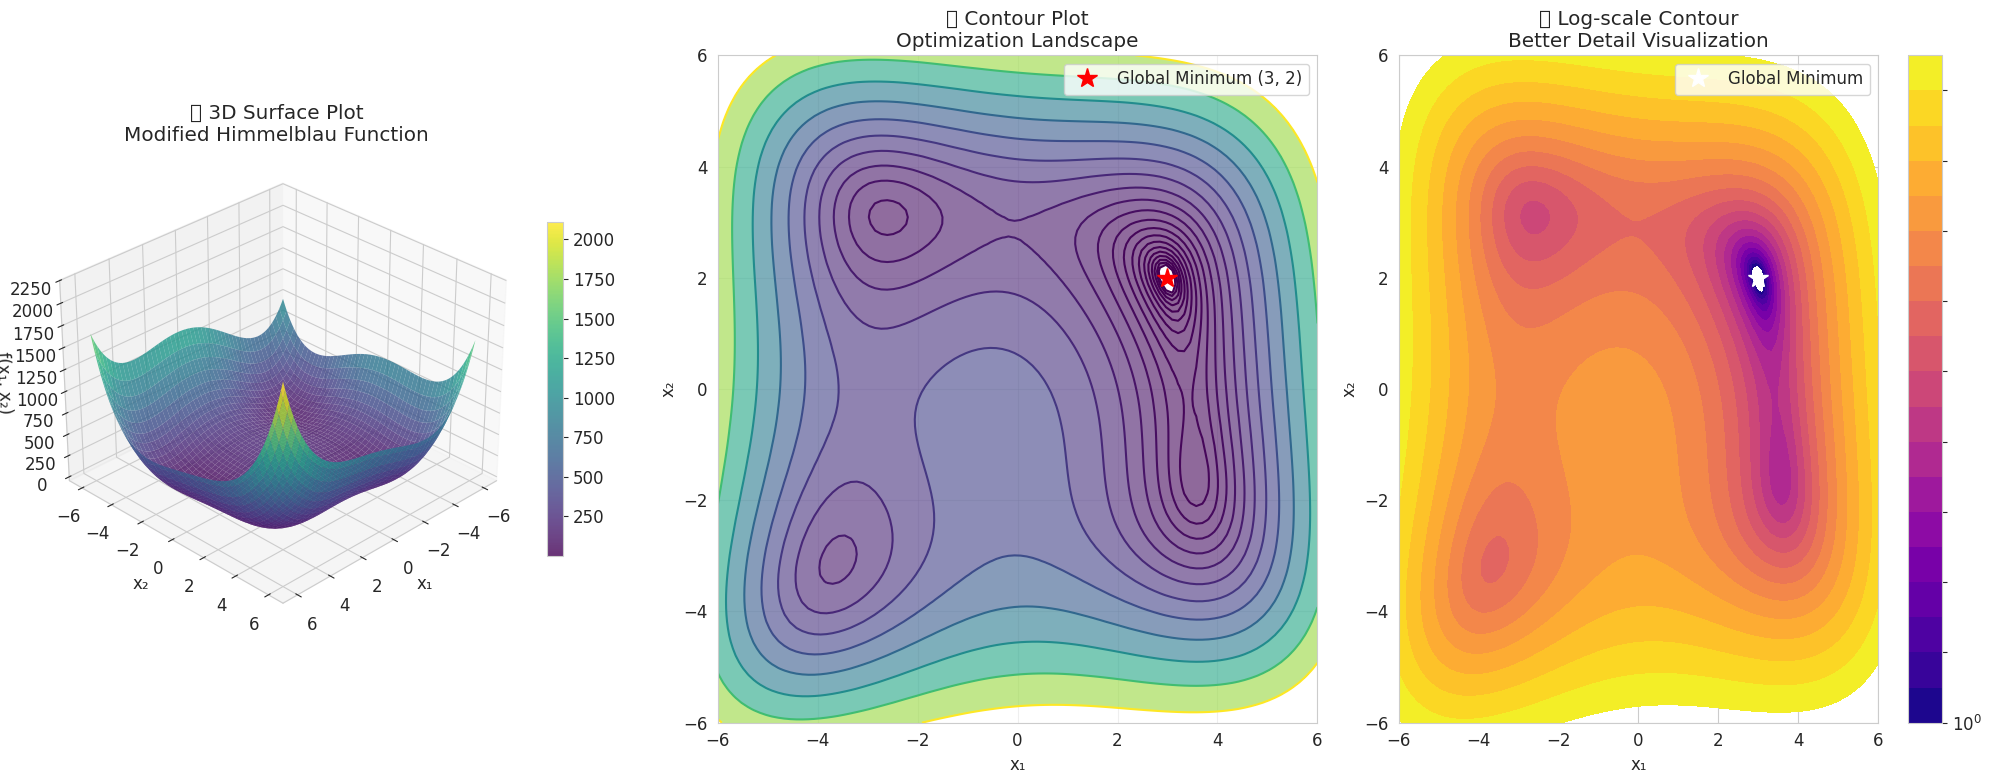

🎨 Visualization complete!
📊 The function has multiple local minima with a preferred global minimum at (3, 2)


In [3]:
# Create a meshgrid for visualization
x_range = np.linspace(-6, 6, 100)
y_range = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x_range, y_range)

# Evaluate function over the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = modified_himmelblau([X[i, j], Y[i, j]])

# Create subplots
fig = plt.figure(figsize=(20, 8))

# 3D surface plot
ax1 = fig.add_subplot(131, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0)
ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_zlabel('f(x₁, x₂)')
ax1.set_title('🏔️ 3D Surface Plot\nModified Himmelblau Function')
ax1.view_init(elev=30, azim=45)
fig.colorbar(surf, ax=ax1, shrink=0.5)

# Contour plot
ax2 = fig.add_subplot(132)
levels = np.logspace(0, 3, 20)  # Logarithmic levels for better visualization
contour = ax2.contour(X, Y, Z, levels=levels, cmap='viridis')
ax2.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.6)
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
ax2.set_title('🗺️ Contour Plot\nOptimization Landscape')
ax2.grid(True, alpha=0.3)

# Mark the global minimum
ax2.plot(3, 2, 'r*', markersize=15, label='Global Minimum (3, 2)')
ax2.legend()

# Log-scale contour for better detail
ax3 = fig.add_subplot(133)
contour_log = ax3.contourf(X, Y, Z, levels=levels, norm=LogNorm(), cmap='plasma')
ax3.set_xlabel('x₁')
ax3.set_ylabel('x₂')
ax3.set_title('🔥 Log-scale Contour\nBetter Detail Visualization')
ax3.plot(3, 2, 'w*', markersize=15, label='Global Minimum')
ax3.legend()
fig.colorbar(contour_log, ax=ax3)

plt.tight_layout()
plt.show()

print("🎨 Visualization complete!")
print("📊 The function has multiple local minima with a preferred global minimum at (3, 2)")

## 🧬 Setting Up the CoFI Optimization Problem

Now let's set up our optimization problem using CoFI's elegant framework:

In [4]:
# Define the optimization problem using CoFI
problem = BaseProblem()
problem.set_objective(modified_himmelblau)  # Our objective function
problem.set_model_shape((2,))               # 2D optimization problem
problem.set_bounds((-6, 6))                 # Search space bounds

print("✅ CoFI Problem Setup Complete!")
print(f"📏 Problem dimension: {np.prod(problem.model_shape)}")
print(f"🎯 Objective function: Modified Himmelblau")
print(f"🔲 Search bounds: {problem.bounds}")
print("\n🚀 Ready for optimization with Slime Mould Algorithm!")

✅ CoFI Problem Setup Complete!
📏 Problem dimension: 2
🎯 Objective function: Modified Himmelblau
🔲 Search bounds: (-6, 6)

🚀 Ready for optimization with Slime Mould Algorithm!


# Configure SMA optimization options
sma_options = InversionOptions()
sma_options.set_tool("mealpy.sma")
sma_options.set_params(
    algorithm="OriginalSMA",  # Use the original SMA variant
    epoch=100,                # Number of iterations
    pop_size=50,             # Population size (number of slime moulds)
    pr=0.03,                 # Probability parameter
    seed=42,                 # For reproducible results
    verbose=False            # Reduce output for cleaner notebook
)

print("⚙️ SMA Configuration:")
print(f"   🔧 Algorithm: OriginalSMA")
print(f"   🔄 Epochs: 100")
print(f"   👥 Population: 50 slime moulds")
print(f"   🎲 Seed: 42 (reproducible results)")

# Run the optimization with comprehensive output suppression
print("\n🚀 Starting SMA optimization...")

# Comprehensive suppression: both stdout and logging
import sys
from io import StringIO

# Store original logging level
original_log_level = logging.getLogger().level

# Suppress both stdout and logging
old_stdout = sys.stdout
old_stderr = sys.stderr
sys.stdout = StringIO()
sys.stderr = StringIO()

try:
    # Suppress mealpy logging
    suppress_mealpy_logging()
    
    sma_inversion = Inversion(problem, sma_options)
    sma_result = sma_inversion.run()
finally:
    # Restore stdout/stderr and logging
    sys.stdout = old_stdout
    sys.stderr = old_stderr
    logging.getLogger().setLevel(original_log_level)

print("🎉 SMA Optimization Complete!")
print(f"✨ Optimal solution: [{sma_result.model[0]:.6f}, {sma_result.model[1]:.6f}]")
print(f"🎯 Objective value: {sma_result.objective:.8f}")
print(f"📊 Success: {sma_result.success}")

# Calculate distance from true optimum
true_optimum = np.array([3.0, 2.0])
distance = np.linalg.norm(sma_result.model - true_optimum)
print(f"📏 Distance from true optimum (3, 2): {distance:.6f}")

In [5]:
# Configure SMA optimization options
sma_options = InversionOptions()
sma_options.set_tool("mealpy.sma")
sma_options.set_params(
    algorithm="OriginalSMA",  # Use the original SMA variant
    epoch=100,                # Number of iterations
    pop_size=50,             # Population size (number of slime moulds)
    pr=0.03,                 # Probability parameter
    seed=42,                 # For reproducible results
    verbose=False            # Reduce output for cleaner notebook
)

print("⚙️ SMA Configuration:")
print(f"   🔧 Algorithm: OriginalSMA")
print(f"   🔄 Epochs: 100")
print(f"   👥 Population: 50 slime moulds")
print(f"   🎲 Seed: 42 (reproducible results)")

# Run the optimization with output suppression
print("\n🚀 Starting SMA optimization...")

# Suppress mealpy output during optimization
import sys
from io import StringIO
old_stdout = sys.stdout
sys.stdout = StringIO()

try:
    sma_inversion = Inversion(problem, sma_options)
    sma_result = sma_inversion.run()
finally:
    sys.stdout = old_stdout

print("🎉 SMA Optimization Complete!")
print(f"✨ Optimal solution: [{sma_result.model[0]:.6f}, {sma_result.model[1]:.6f}]")
print(f"🎯 Objective value: {sma_result.objective:.8f}")
print(f"📊 Success: {sma_result.success}")

# Calculate distance from true optimum
true_optimum = np.array([3.0, 2.0])
distance = np.linalg.norm(sma_result.model - true_optimum)
print(f"📏 Distance from true optimum (3, 2): {distance:.6f}")

2025/08/13 01:26:12 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=100, pop_size=50, p_t=0.03)


2025/08/13 01:26:12 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 14.768931483955226, Global best: 6.24276945111367, Runtime: 0.00715 seconds


2025/08/13 01:26:12 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 3.1382684094083877, Global best: 3.1382684094083877, Runtime: 0.00747 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 2.737984884548368, Global best: 2.737984884548368, Runtime: 0.00707 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 6.527147956126921, Global best: 2.737984884548368, Runtime: 0.00717 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 12.633932009705614, Global best: 2.737984884548368, Runtime: 0.00791 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 1.9857302485109554, Global best: 1.9857302485109554, Runtime: 0.00717 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 0.5577343701193539, Global best: 0.5577343701193539, Runtime: 0.00873 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 1.8923893574452277, Global best: 0.5577343701193539, Runtime: 0.00697 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 0.35683561125419005, Global best: 0.35683561125419005, Runtime: 0.00756 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.025639883943811757, Global best: 0.025639883943811757, Runtime: 0.00761 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 0.7826353841325808, Global best: 0.025639883943811757, Runtime: 0.00751 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 0.16764127022787914, Global best: 0.025639883943811757, Runtime: 0.00741 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 1.4804062924612622, Global best: 0.025639883943811757, Runtime: 0.00696 seconds


⚙️ SMA Configuration:
   🔧 Algorithm: OriginalSMA
   🔄 Epochs: 100
   👥 Population: 50 slime moulds
   🎲 Seed: 42 (reproducible results)

🚀 Starting SMA optimization...


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 1.1837561133583645, Global best: 0.025639883943811757, Runtime: 0.00773 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.0798441838630835, Global best: 0.025639883943811757, Runtime: 0.00772 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.07135664827100295, Global best: 0.025639883943811757, Runtime: 0.00641 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 1.0170192701458682, Global best: 0.025639883943811757, Runtime: 0.00782 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 1.3899658895019193, Global best: 0.025639883943811757, Runtime: 0.00720 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 1.5082491921802912, Global best: 0.025639883943811757, Runtime: 0.00779 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.03374251938972819, Global best: 0.025639883943811757, Runtime: 0.00709 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 4.697318464342722, Global best: 0.025639883943811757, Runtime: 0.00754 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.21719573979798168, Global best: 0.025639883943811757, Runtime: 0.00711 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.005102082578389179, Global best: 0.005102082578389179, Runtime: 0.00779 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.11577334967574096, Global best: 0.005102082578389179, Runtime: 0.00731 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.07760462994631237, Global best: 0.005102082578389179, Runtime: 0.00742 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.21466585234965388, Global best: 0.005102082578389179, Runtime: 0.00732 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.051510114959550636, Global best: 0.005102082578389179, Runtime: 0.00697 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.5409293500098725, Global best: 0.005102082578389179, Runtime: 0.00714 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.128887774943448, Global best: 0.005102082578389179, Runtime: 0.00686 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.2396432790908819, Global best: 0.005102082578389179, Runtime: 0.00738 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.21508364417358114, Global best: 0.005102082578389179, Runtime: 0.00693 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.08490659239701209, Global best: 0.005102082578389179, Runtime: 0.00704 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.03407222159056599, Global best: 0.005102082578389179, Runtime: 0.00664 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.18139054934896126, Global best: 0.005102082578389179, Runtime: 0.00721 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.02742045899368211, Global best: 0.005102082578389179, Runtime: 0.00711 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.0341422790164512, Global best: 0.005102082578389179, Runtime: 0.00759 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.0015990823324029963, Global best: 0.0015990823324029963, Runtime: 0.00709 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.020053998229820676, Global best: 0.0015990823324029963, Runtime: 0.00748 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.026606638237656487, Global best: 0.0015990823324029963, Runtime: 0.00765 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.012935348065343057, Global best: 0.0015990823324029963, Runtime: 0.00681 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.008594980453603532, Global best: 0.0015990823324029963, Runtime: 0.00774 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.034278282946819415, Global best: 0.0015990823324029963, Runtime: 0.00692 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.005364865571525621, Global best: 0.0015990823324029963, Runtime: 0.00771 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.004588491553094483, Global best: 0.0015990823324029963, Runtime: 0.00712 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.06758014215438815, Global best: 0.0015990823324029963, Runtime: 0.00807 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.0031950371965036133, Global best: 0.0015990823324029963, Runtime: 0.00699 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.0670660279945172, Global best: 0.0015990823324029963, Runtime: 0.00780 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.01973066083562699, Global best: 0.0015990823324029963, Runtime: 0.00751 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.19887809014369864, Global best: 0.0015990823324029963, Runtime: 0.00706 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.040292751096887736, Global best: 0.0015990823324029963, Runtime: 0.00732 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.007362775447368245, Global best: 0.0015990823324029963, Runtime: 0.00717 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.007767089241248479, Global best: 0.0015990823324029963, Runtime: 0.00714 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.1068860234400464, Global best: 0.0015990823324029963, Runtime: 0.00690 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 0.03855428544349443, Global best: 0.0015990823324029963, Runtime: 0.00718 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.008020122379334289, Global best: 0.0015990823324029963, Runtime: 0.00766 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 0.0011662494828868107, Global best: 0.0011662494828868107, Runtime: 0.00711 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 0.014976775547714954, Global best: 0.0011662494828868107, Runtime: 0.00740 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 0.08117224153644065, Global best: 0.0011662494828868107, Runtime: 0.00756 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 0.005238274470359643, Global best: 0.0011662494828868107, Runtime: 0.00732 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 0.00901272431724165, Global best: 0.0011662494828868107, Runtime: 0.00781 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 61, Current best: 0.021883155803498658, Global best: 0.0011662494828868107, Runtime: 0.00715 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 62, Current best: 0.015354528828216493, Global best: 0.0011662494828868107, Runtime: 0.00777 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 63, Current best: 0.11332626186270343, Global best: 0.0011662494828868107, Runtime: 0.00697 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 64, Current best: 0.001609223298965116, Global best: 0.0011662494828868107, Runtime: 0.00733 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 65, Current best: 0.02014243567682242, Global best: 0.0011662494828868107, Runtime: 0.00760 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 66, Current best: 0.008152144452034047, Global best: 0.0011662494828868107, Runtime: 0.00752 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 67, Current best: 0.013510012482924286, Global best: 0.0011662494828868107, Runtime: 0.00775 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 68, Current best: 0.004811982455380401, Global best: 0.0011662494828868107, Runtime: 0.00700 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 69, Current best: 0.004691233116411197, Global best: 0.0011662494828868107, Runtime: 0.00805 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 70, Current best: 0.001683099556041618, Global best: 0.0011662494828868107, Runtime: 0.00733 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 71, Current best: 0.017682114758736264, Global best: 0.0011662494828868107, Runtime: 0.00781 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 72, Current best: 0.025925665176572316, Global best: 0.0011662494828868107, Runtime: 0.00707 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 73, Current best: 0.00030119135467556775, Global best: 0.00030119135467556775, Runtime: 0.00756 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 74, Current best: 0.0026073533444880316, Global best: 0.00030119135467556775, Runtime: 0.00710 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 75, Current best: 0.0014753323833527944, Global best: 0.00030119135467556775, Runtime: 0.00755 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 76, Current best: 0.001942207268989145, Global best: 0.00030119135467556775, Runtime: 0.00796 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 77, Current best: 0.004201566261904567, Global best: 0.00030119135467556775, Runtime: 0.00723 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 78, Current best: 0.002528086003220743, Global best: 0.00030119135467556775, Runtime: 0.00712 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 79, Current best: 0.003839819175798215, Global best: 0.00030119135467556775, Runtime: 0.00760 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 80, Current best: 0.0001820809532342265, Global best: 0.0001820809532342265, Runtime: 0.00702 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 81, Current best: 0.014900182737616672, Global best: 0.0001820809532342265, Runtime: 0.00742 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 82, Current best: 0.0003254165956990722, Global best: 0.0001820809532342265, Runtime: 0.00711 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 83, Current best: 0.01681201354778671, Global best: 0.0001820809532342265, Runtime: 0.00823 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 84, Current best: 4.7483206682533765e-05, Global best: 4.7483206682533765e-05, Runtime: 0.00702 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 85, Current best: 0.0015016615230841288, Global best: 4.7483206682533765e-05, Runtime: 0.00760 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 86, Current best: 4.774557859674086e-06, Global best: 4.774557859674086e-06, Runtime: 0.00729 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 87, Current best: 0.0006786244788060467, Global best: 4.774557859674086e-06, Runtime: 0.00708 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 88, Current best: 3.163854249610831e-05, Global best: 4.774557859674086e-06, Runtime: 0.00741 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 89, Current best: 0.00020875097909338667, Global best: 4.774557859674086e-06, Runtime: 0.00742 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 90, Current best: 0.0003723233733098022, Global best: 4.774557859674086e-06, Runtime: 0.00766 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 91, Current best: 0.0005791295875076813, Global best: 4.774557859674086e-06, Runtime: 0.00710 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 92, Current best: 5.2917164406517346e-05, Global best: 4.774557859674086e-06, Runtime: 0.00760 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 93, Current best: 9.206806544462769e-05, Global best: 4.774557859674086e-06, Runtime: 0.00714 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 94, Current best: 2.5051677058673874e-06, Global best: 2.5051677058673874e-06, Runtime: 0.00799 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 95, Current best: 6.604262202735405e-06, Global best: 2.5051677058673874e-06, Runtime: 0.00708 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 96, Current best: 1.8079131581004086e-05, Global best: 2.5051677058673874e-06, Runtime: 0.00812 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 97, Current best: 1.468230254032154e-05, Global best: 2.5051677058673874e-06, Runtime: 0.00709 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 98, Current best: 3.2762459608219234e-06, Global best: 2.5051677058673874e-06, Runtime: 0.00721 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 99, Current best: 1.0991049077845409e-06, Global best: 1.0991049077845409e-06, Runtime: 0.00741 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 100, Current best: 1.0991049077845409e-06, Global best: 1.0991049077845409e-06, Runtime: 0.00721 seconds


🎉 SMA Optimization Complete!
✨ Optimal solution: [3.000099, 2.000153]
🎯 Objective value: 0.00000110
📊 Success: True
📏 Distance from true optimum (3, 2): 0.000182


# Compare different SMA algorithms
algorithms = ["OriginalSMA", "DevSMA"]
results = {}
colors = ['#FF6B6B', '#4ECDC4']

print("🔬 Comparing SMA Algorithm Variants...\n")

# Comprehensive suppression setup
import sys
from io import StringIO

for i, algo in enumerate(algorithms):
    # Configure options for each algorithm
    options = InversionOptions()
    options.set_tool("mealpy.sma")
    options.set_params(
        algorithm=algo,
        epoch=80,
        pop_size=40,
        seed=42
    )
    
    # Run optimization with comprehensive suppression
    print(f"🧬 Running {algo}...")
    
    # Store original state
    original_log_level = logging.getLogger().level
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    
    # Suppress all output
    sys.stdout = StringIO()
    sys.stderr = StringIO()
    
    try:
        suppress_mealpy_logging()
        inversion = Inversion(problem, options)
        result = inversion.run()
    finally:
        # Restore original state
        sys.stdout = old_stdout
        sys.stderr = old_stderr
        logging.getLogger().setLevel(original_log_level)
    
    # Store results
    results[algo] = {
        'solution': result.model,
        'objective': result.objective,
        'distance': np.linalg.norm(result.model - true_optimum)
    }
    
    print(f"   ✅ Solution: [{result.model[0]:.4f}, {result.model[1]:.4f}]")
    print(f"   🎯 Objective: {result.objective:.6f}")
    print(f"   📏 Distance: {results[algo]['distance']:.6f}\n")

print("📊 Algorithm Comparison Complete!")

In [6]:
# Compare different SMA algorithms
algorithms = ["OriginalSMA", "DevSMA"]
results = {}
colors = ['#FF6B6B', '#4ECDC4']

print("🔬 Comparing SMA Algorithm Variants...\n")

# Suppress mealpy output during optimization runs
import sys
from io import StringIO

for i, algo in enumerate(algorithms):
    # Configure options for each algorithm
    options = InversionOptions()
    options.set_tool("mealpy.sma")
    options.set_params(
        algorithm=algo,
        epoch=80,
        pop_size=40,
        seed=42
    )
    
    # Run optimization with suppressed output
    print(f"🧬 Running {algo}...")
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    
    try:
        inversion = Inversion(problem, options)
        result = inversion.run()
    finally:
        sys.stdout = old_stdout
    
    # Store results
    results[algo] = {
        'solution': result.model,
        'objective': result.objective,
        'distance': np.linalg.norm(result.model - true_optimum)
    }
    
    print(f"   ✅ Solution: [{result.model[0]:.4f}, {result.model[1]:.4f}]")
    print(f"   🎯 Objective: {result.objective:.6f}")
    print(f"   📏 Distance: {results[algo]['distance']:.6f}\n")

print("📊 Algorithm Comparison Complete!")

2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=80, pop_size=40, p_t=0.03)


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 24.55594122567567, Global best: 1.418842905287672, Runtime: 0.00605 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 1.3319125568601475, Global best: 1.3319125568601475, Runtime: 0.00645 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 0.47524421740548706, Global best: 0.47524421740548706, Runtime: 0.00573 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 4.497471998660818, Global best: 0.47524421740548706, Runtime: 0.00556 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 16.45897740476692, Global best: 0.47524421740548706, Runtime: 0.00565 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 2.7179765418441044, Global best: 0.47524421740548706, Runtime: 0.00650 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 5.576838589858379, Global best: 0.47524421740548706, Runtime: 0.00572 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 0.32923911192014305, Global best: 0.32923911192014305, Runtime: 0.00678 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 17.52640490766707, Global best: 0.32923911192014305, Runtime: 0.00607 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.4957529486334965, Global best: 0.32923911192014305, Runtime: 0.00577 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 1.6028363743554725, Global best: 0.32923911192014305, Runtime: 0.00563 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 1.0616736766862085, Global best: 0.32923911192014305, Runtime: 0.00531 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 0.3813072516744944, Global best: 0.32923911192014305, Runtime: 0.00594 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.5151821858068899, Global best: 0.32923911192014305, Runtime: 0.00580 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.2025112918747473, Global best: 0.2025112918747473, Runtime: 0.00591 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.09106588338185972, Global best: 0.09106588338185972, Runtime: 0.00572 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 1.2963594093050932, Global best: 0.09106588338185972, Runtime: 0.00663 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.14215571542747046, Global best: 0.09106588338185972, Runtime: 0.00549 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.11123245768285672, Global best: 0.09106588338185972, Runtime: 0.00520 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.004577179295319436, Global best: 0.004577179295319436, Runtime: 0.00610 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.049493629159452275, Global best: 0.004577179295319436, Runtime: 0.00555 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.6674141663946787, Global best: 0.004577179295319436, Runtime: 0.00581 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.05834989998209961, Global best: 0.004577179295319436, Runtime: 0.00586 seconds


2025/08/13 01:26:13 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.14713206980151713, Global best: 0.004577179295319436, Runtime: 0.00552 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 1.5058243050478506, Global best: 0.004577179295319436, Runtime: 0.00580 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.006471888918230788, Global best: 0.004577179295319436, Runtime: 0.00696 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.065577399625802, Global best: 0.004577179295319436, Runtime: 0.00530 seconds


🔬 Comparing SMA Algorithm Variants...

🧬 Running OriginalSMA...


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.24677990692579274, Global best: 0.004577179295319436, Runtime: 0.00629 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.003047512681019879, Global best: 0.003047512681019879, Runtime: 0.00559 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.0006674385261533252, Global best: 0.0006674385261533252, Runtime: 0.00628 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.13242327840466903, Global best: 0.0006674385261533252, Runtime: 0.00556 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.1717029742002853, Global best: 0.0006674385261533252, Runtime: 0.00602 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.0005477327676988085, Global best: 0.0005477327676988085, Runtime: 0.00596 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.13629520865737235, Global best: 0.0005477327676988085, Runtime: 0.00675 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.054393665283340796, Global best: 0.0005477327676988085, Runtime: 0.00514 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.0020426573508491733, Global best: 0.0005477327676988085, Runtime: 0.00571 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.00044910192740027033, Global best: 0.00044910192740027033, Runtime: 0.00584 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.004472919079064575, Global best: 0.00044910192740027033, Runtime: 0.00604 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.03047593773139338, Global best: 0.00044910192740027033, Runtime: 0.00574 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.2679375782930034, Global best: 0.00044910192740027033, Runtime: 0.00570 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.02815299847724507, Global best: 0.00044910192740027033, Runtime: 0.00599 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.10633493474169244, Global best: 0.00044910192740027033, Runtime: 0.00560 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.002302773053848114, Global best: 0.00044910192740027033, Runtime: 0.00607 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.010466710495417092, Global best: 0.00044910192740027033, Runtime: 0.00573 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.2361329087838932, Global best: 0.00044910192740027033, Runtime: 0.00582 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.003088689571590955, Global best: 0.00044910192740027033, Runtime: 0.00558 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.05132246074737249, Global best: 0.00044910192740027033, Runtime: 0.00557 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.008095943551859297, Global best: 0.00044910192740027033, Runtime: 0.00563 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.012536780909501652, Global best: 0.00044910192740027033, Runtime: 0.00628 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.1590569152861366, Global best: 0.00044910192740027033, Runtime: 0.00546 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.052305382277731266, Global best: 0.00044910192740027033, Runtime: 0.00612 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.012850786326584726, Global best: 0.00044910192740027033, Runtime: 0.00553 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.07523143532035713, Global best: 0.00044910192740027033, Runtime: 0.00569 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 9.0554609138057e-06, Global best: 9.0554609138057e-06, Runtime: 0.00620 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.006839152857073162, Global best: 9.0554609138057e-06, Runtime: 0.00884 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 0.0005748307008415195, Global best: 9.0554609138057e-06, Runtime: 0.00552 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 0.003313043129943413, Global best: 9.0554609138057e-06, Runtime: 0.00555 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 0.0009401879090045732, Global best: 9.0554609138057e-06, Runtime: 0.00607 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 0.0013611779075370068, Global best: 9.0554609138057e-06, Runtime: 0.00591 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 0.007029777413085914, Global best: 9.0554609138057e-06, Runtime: 0.00560 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 61, Current best: 2.1711023985858444e-05, Global best: 9.0554609138057e-06, Runtime: 0.00635 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 62, Current best: 0.014754109986209716, Global best: 9.0554609138057e-06, Runtime: 0.00600 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 63, Current best: 0.011707772008097065, Global best: 9.0554609138057e-06, Runtime: 0.00588 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 64, Current best: 0.000539455188300203, Global best: 9.0554609138057e-06, Runtime: 0.00598 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 65, Current best: 0.010999176808770056, Global best: 9.0554609138057e-06, Runtime: 0.00563 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 66, Current best: 0.0027384428390304994, Global best: 9.0554609138057e-06, Runtime: 0.00625 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 67, Current best: 0.00012731626420930869, Global best: 9.0554609138057e-06, Runtime: 0.00649 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 68, Current best: 9.36950745936262e-05, Global best: 9.0554609138057e-06, Runtime: 0.00593 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 69, Current best: 0.002509308824386101, Global best: 9.0554609138057e-06, Runtime: 0.00631 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 70, Current best: 0.004202461839090883, Global best: 9.0554609138057e-06, Runtime: 0.00517 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 71, Current best: 0.0009393511558528563, Global best: 9.0554609138057e-06, Runtime: 0.00594 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 72, Current best: 0.0017934762964458483, Global best: 9.0554609138057e-06, Runtime: 0.00571 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 73, Current best: 0.00013478124928983167, Global best: 9.0554609138057e-06, Runtime: 0.00667 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 74, Current best: 9.610631364726874e-05, Global best: 9.0554609138057e-06, Runtime: 0.00548 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 75, Current best: 0.00010220698283893561, Global best: 9.0554609138057e-06, Runtime: 0.00589 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 76, Current best: 2.8688335913935577e-05, Global best: 9.0554609138057e-06, Runtime: 0.00573 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 77, Current best: 2.2007959995438843e-05, Global best: 9.0554609138057e-06, Runtime: 0.00542 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 78, Current best: 6.981266976423784e-06, Global best: 6.981266976423784e-06, Runtime: 0.00668 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 79, Current best: 1.3562362236791926e-06, Global best: 1.3562362236791926e-06, Runtime: 0.00516 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 80, Current best: 1.3562362236791926e-06, Global best: 1.3562362236791926e-06, Runtime: 0.00521 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: DevSMA(epoch=80, pop_size=40, p_t=0.03)


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 1, Current best: 0.9347437174222579, Global best: 0.9347437174222579, Runtime: 0.00600 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 2, Current best: 0.025005179761909555, Global best: 0.025005179761909555, Runtime: 0.00533 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 3, Current best: 0.025005179761909555, Global best: 0.025005179761909555, Runtime: 0.00571 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 4, Current best: 0.025005179761909555, Global best: 0.025005179761909555, Runtime: 0.00523 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 5, Current best: 0.025005179761909555, Global best: 0.025005179761909555, Runtime: 0.00511 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 6, Current best: 0.022956525054422316, Global best: 0.022956525054422316, Runtime: 0.00562 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 7, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00527 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 8, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00545 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 9, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00549 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 10, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00524 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 11, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00568 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 12, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00537 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 13, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00536 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 14, Current best: 0.013833019986395734, Global best: 0.013833019986395734, Runtime: 0.00576 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 15, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00574 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 16, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00585 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 17, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00516 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 18, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00473 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 19, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00557 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 20, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00525 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 21, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00564 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 22, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00553 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 23, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00581 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 24, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00528 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 25, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00580 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 26, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00543 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 27, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00526 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 28, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00518 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 29, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00510 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 30, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00596 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 31, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00499 seconds


   ✅ Solution: [2.9999, 2.0003]
   🎯 Objective: 0.000001
   📏 Distance: 0.000309

🧬 Running DevSMA...


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 32, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00595 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 33, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00548 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 34, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00543 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 35, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00519 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 36, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00588 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 37, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00548 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 38, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00522 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 39, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00575 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 40, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00534 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 41, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00579 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 42, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00538 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 43, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00520 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 44, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00598 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 45, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00523 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 46, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00567 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 47, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00558 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 48, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00519 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 49, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00521 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 50, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00579 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 51, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00531 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 52, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00547 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 53, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00555 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 54, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00514 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 55, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00622 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 56, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00542 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 57, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00587 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 58, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00583 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 59, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00523 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 60, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00609 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 61, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00528 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 62, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00550 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 63, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00532 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 64, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00560 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 65, Current best: 0.008039744953646013, Global best: 0.008039744953646013, Runtime: 0.00521 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 66, Current best: 0.0034376315657875687, Global best: 0.0034376315657875687, Runtime: 0.00594 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 67, Current best: 0.0034376315657875687, Global best: 0.0034376315657875687, Runtime: 0.00531 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 68, Current best: 0.0034376315657875687, Global best: 0.0034376315657875687, Runtime: 0.00530 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 69, Current best: 0.0034376315657875687, Global best: 0.0034376315657875687, Runtime: 0.00549 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 70, Current best: 0.001376424142084878, Global best: 0.001376424142084878, Runtime: 0.00516 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 71, Current best: 0.001376424142084878, Global best: 0.001376424142084878, Runtime: 0.00543 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 72, Current best: 0.001376424142084878, Global best: 0.001376424142084878, Runtime: 0.00558 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 73, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00554 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 74, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00515 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 75, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00527 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 76, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00545 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 77, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00589 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 78, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00581 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 79, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00530 seconds


2025/08/13 01:26:14 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 80, Current best: 9.374933580888492e-05, Global best: 9.374933580888492e-05, Runtime: 0.00630 seconds


   ✅ Solution: [3.0016, 1.9983]
   🎯 Objective: 0.000094
   📏 Distance: 0.002307

📊 Algorithm Comparison Complete!


/tmp/ipykernel_224803/1007014702.py:80: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/tmp/ipykernel_224803/1007014702.py:80: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/tmp/ipykernel_224803/1007014702.py:80: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/1007014702.py:80: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


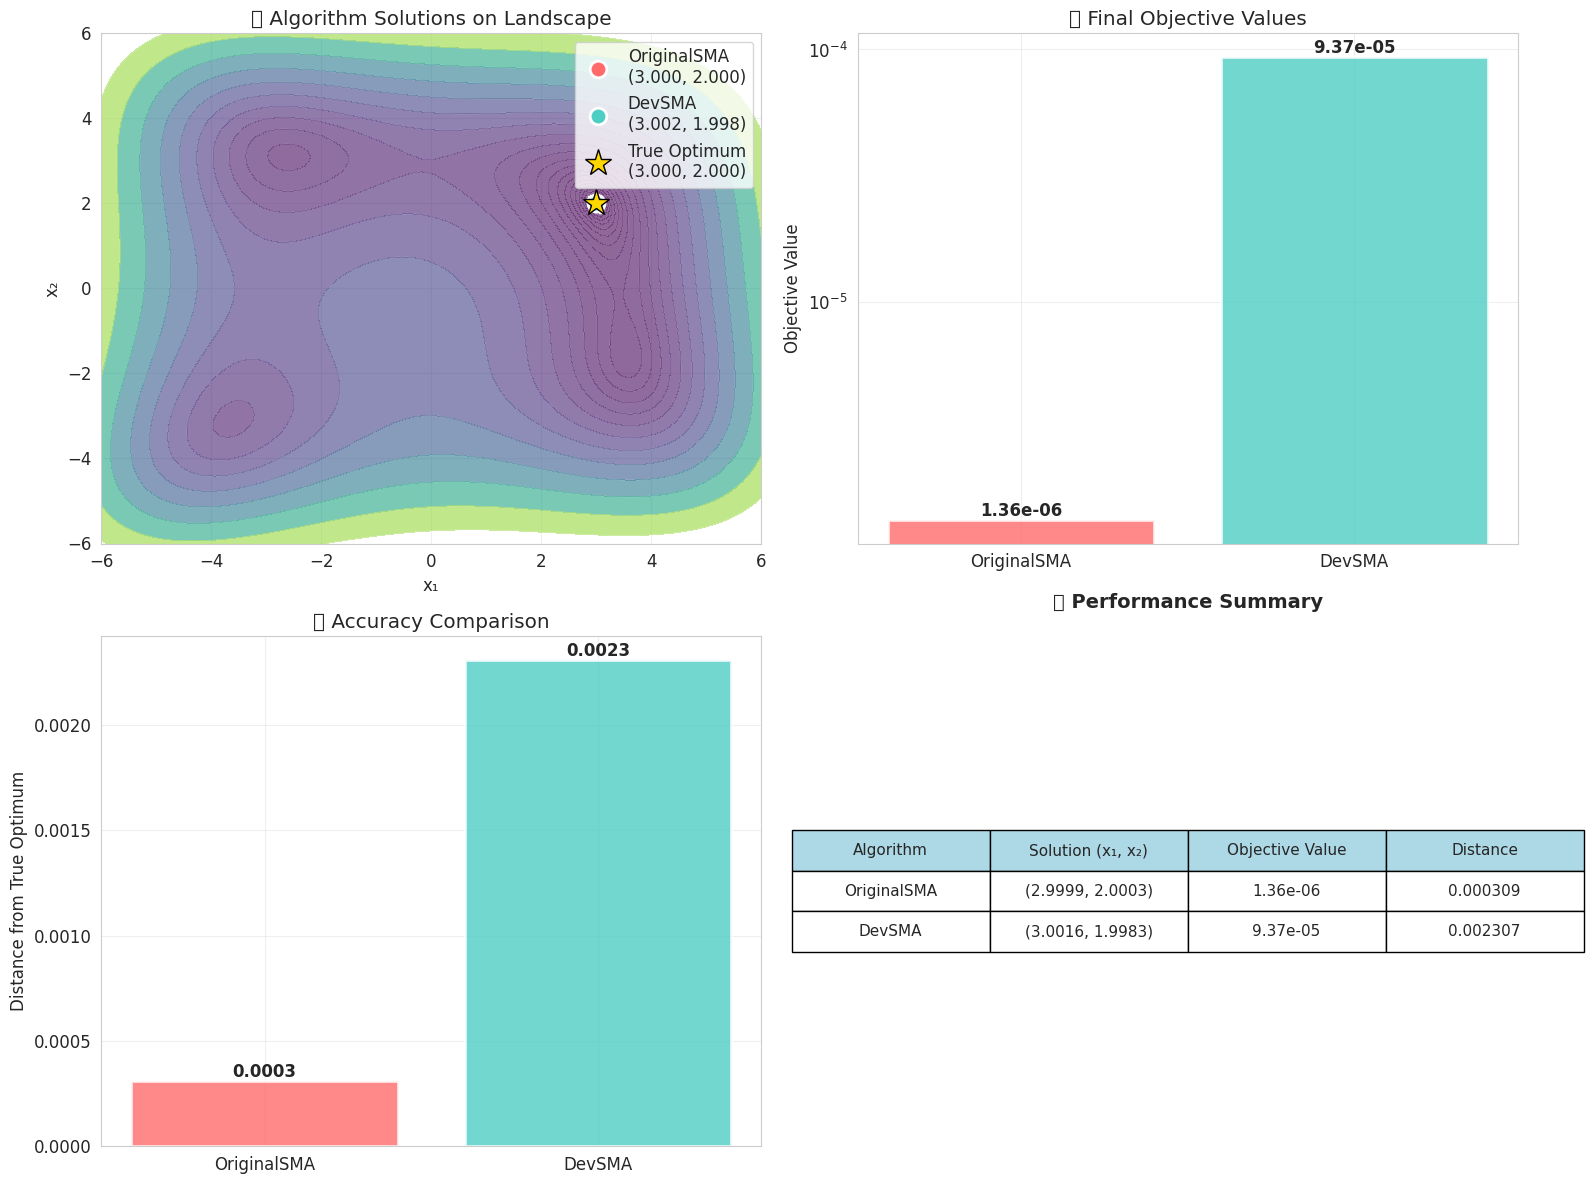

📊 Comprehensive algorithm comparison visualization complete!


In [7]:
# Visualize the comparison results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Solutions on contour plot
contour = ax1.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.6)
ax1.contour(X, Y, Z, levels=levels, colors='white', alpha=0.3, linewidths=0.5)

# Plot solutions
for i, (algo, result) in enumerate(results.items()):
    ax1.plot(result['solution'][0], result['solution'][1], 
            'o', color=colors[i], markersize=12, 
            label=f'{algo}\n({result["solution"][0]:.3f}, {result["solution"][1]:.3f})',
            markeredgecolor='white', markeredgewidth=2)

# Mark true optimum
ax1.plot(3, 2, '*', color='gold', markersize=20, 
        label='True Optimum\n(3.000, 2.000)',
        markeredgecolor='black', markeredgewidth=1)

ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_title('🗺️ Algorithm Solutions on Landscape')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Objective values comparison
algos = list(results.keys())
objectives = [results[algo]['objective'] for algo in algos]
bars = ax2.bar(algos, objectives, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
ax2.set_ylabel('Objective Value')
ax2.set_title('🎯 Final Objective Values')
ax2.set_yscale('log')  # Log scale for better comparison
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, obj in zip(bars, objectives):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{obj:.2e}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Distance from optimum
distances = [results[algo]['distance'] for algo in algos]
bars = ax3.bar(algos, distances, color=colors, alpha=0.8, edgecolor='white', linewidth=2)
ax3.set_ylabel('Distance from True Optimum')
ax3.set_title('📏 Accuracy Comparison')
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, dist in zip(bars, distances):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{dist:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Performance summary table
ax4.axis('tight')
ax4.axis('off')

# Create table data
table_data = []
for algo in algos:
    result = results[algo]
    table_data.append([
        algo,
        f"({result['solution'][0]:.4f}, {result['solution'][1]:.4f})",
        f"{result['objective']:.2e}",
        f"{result['distance']:.6f}"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=['Algorithm', 'Solution (x₁, x₂)', 'Objective Value', 'Distance'],
                 cellLoc='center',
                 loc='center',
                 colColours=['lightblue']*4)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)
ax4.set_title('📋 Performance Summary', pad=20, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Comprehensive algorithm comparison visualization complete!")

# Multiple runs for statistical analysis
n_runs = 10
seeds = range(42, 42 + n_runs)

print(f"🎲 Running {n_runs} independent SMA optimizations...\n")

multi_results = {
    'solutions': [],
    'objectives': [],
    'distances': []
}

# Comprehensive suppression setup
import sys
from io import StringIO

for i, seed in enumerate(seeds):
    # Configure options
    options = InversionOptions()
    options.set_tool("mealpy.sma")
    options.set_params(
        algorithm="OriginalSMA",
        epoch=60,
        pop_size=30,
        seed=seed
    )
    
    # Store original state
    original_log_level = logging.getLogger().level
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    
    # Suppress all output
    sys.stdout = StringIO()
    sys.stderr = StringIO()
    
    try:
        suppress_mealpy_logging()
        inversion = Inversion(problem, options)
        result = inversion.run()
    finally:
        # Restore original state
        sys.stdout = old_stdout
        sys.stderr = old_stderr
        logging.getLogger().setLevel(original_log_level)
    
    # Store results
    multi_results['solutions'].append(result.model)
    multi_results['objectives'].append(result.objective)
    distance = np.linalg.norm(result.model - true_optimum)
    multi_results['distances'].append(distance)
    
    print(f"Run {i+1:2d}: [{result.model[0]:.4f}, {result.model[1]:.4f}] | "
          f"Obj: {result.objective:.2e} | Dist: {distance:.4f}")

# Statistical analysis
objectives = np.array(multi_results['objectives'])
distances = np.array(multi_results['distances'])

print("\n📈 Statistical Summary:")
print(f"🎯 Objective - Mean: {objectives.mean():.2e}, Std: {objectives.std():.2e}")
print(f"📏 Distance  - Mean: {distances.mean():.4f}, Std: {distances.std():.4f}")
print(f"🏆 Best objective: {objectives.min():.2e}")
print(f"🎯 Success rate (dist < 0.1): {(distances < 0.1).sum()}/{n_runs} ({100*(distances < 0.1).mean():.1f}%)")

In [8]:
# Multiple runs for statistical analysis
n_runs = 10
seeds = range(42, 42 + n_runs)

print(f"🎲 Running {n_runs} independent SMA optimizations...\n")

multi_results = {
    'solutions': [],
    'objectives': [],
    'distances': []
}

# Suppress mealpy output during runs
import sys
from io import StringIO

for i, seed in enumerate(seeds):
    # Configure options
    options = InversionOptions()
    options.set_tool("mealpy.sma")
    options.set_params(
        algorithm="OriginalSMA",
        epoch=60,
        pop_size=30,
        seed=seed
    )
    
    # Run optimization with suppressed output
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    
    try:
        inversion = Inversion(problem, options)
        result = inversion.run()
    finally:
        sys.stdout = old_stdout
    
    # Store results
    multi_results['solutions'].append(result.model)
    multi_results['objectives'].append(result.objective)
    distance = np.linalg.norm(result.model - true_optimum)
    multi_results['distances'].append(distance)
    
    print(f"Run {i+1:2d}: [{result.model[0]:.4f}, {result.model[1]:.4f}] | "
          f"Obj: {result.objective:.2e} | Dist: {distance:.4f}")

# Statistical analysis
objectives = np.array(multi_results['objectives'])
distances = np.array(multi_results['distances'])

print("\n📈 Statistical Summary:")
print(f"🎯 Objective - Mean: {objectives.mean():.2e}, Std: {objectives.std():.2e}")
print(f"📏 Distance  - Mean: {distances.mean():.4f}, Std: {distances.std():.4f}")
print(f"🏆 Best objective: {objectives.min():.2e}")
print(f"🎯 Success rate (dist < 0.1): {(distances < 0.1).sum()}/{n_runs} ({100*(distances < 0.1).mean():.1f}%)")

2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 81.28444596254285, Global best: 53.83690733412215, Runtime: 0.00526 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 2.8866115393629124, Global best: 2.8866115393629124, Runtime: 0.00451 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 2.9138611171232474, Global best: 2.8866115393629124, Runtime: 0.00417 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 17.05232589043964, Global best: 2.8866115393629124, Runtime: 0.00461 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 2.4761770405972263, Global best: 2.4761770405972263, Runtime: 0.00427 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 4.508399332586102, Global best: 2.4761770405972263, Runtime: 0.00509 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 3.960897931673105, Global best: 2.4761770405972263, Runtime: 0.00474 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 1.6786783050670866, Global best: 1.6786783050670866, Runtime: 0.00458 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 1.700641784183348, Global best: 1.6786783050670866, Runtime: 0.00446 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.6126946981462955, Global best: 0.6126946981462955, Runtime: 0.00473 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 1.7263757854695516, Global best: 0.6126946981462955, Runtime: 0.00439 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 0.5190714189604768, Global best: 0.5190714189604768, Runtime: 0.00418 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 7.401218107319903, Global best: 0.5190714189604768, Runtime: 0.00480 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.00047890216737677744, Global best: 0.00047890216737677744, Runtime: 0.00431 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.7872661053387221, Global best: 0.00047890216737677744, Runtime: 0.00521 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.06941485798730276, Global best: 0.00047890216737677744, Runtime: 0.00417 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.42997201682243197, Global best: 0.00047890216737677744, Runtime: 0.00456 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.6759637064606138, Global best: 0.00047890216737677744, Runtime: 0.00465 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.33490735833062835, Global best: 0.00047890216737677744, Runtime: 0.00422 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.3409553148542516, Global best: 0.00047890216737677744, Runtime: 0.00536 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.27491327598161613, Global best: 0.00047890216737677744, Runtime: 0.00427 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.03337271644278225, Global best: 0.00047890216737677744, Runtime: 0.00461 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.10855258620068373, Global best: 0.00047890216737677744, Runtime: 0.00469 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.08922955396808126, Global best: 0.00047890216737677744, Runtime: 0.00433 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.10444247633490786, Global best: 0.00047890216737677744, Runtime: 0.00419 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.09681564702853894, Global best: 0.00047890216737677744, Runtime: 0.00469 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.004340807377751751, Global best: 0.00047890216737677744, Runtime: 0.00449 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 1.810896853662165, Global best: 0.00047890216737677744, Runtime: 0.00419 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.1553722486465833, Global best: 0.00047890216737677744, Runtime: 0.00551 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.036358780891951326, Global best: 0.00047890216737677744, Runtime: 0.00433 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.0024267027248384733, Global best: 0.00047890216737677744, Runtime: 0.00408 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.32788448823585675, Global best: 0.00047890216737677744, Runtime: 0.00431 seconds


🎲 Running 10 independent SMA optimizations...



2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.02744017016914435, Global best: 0.00047890216737677744, Runtime: 0.00461 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.0032487983661707875, Global best: 0.00047890216737677744, Runtime: 0.00560 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.00021951451436551006, Global best: 0.00021951451436551006, Runtime: 0.00416 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.03916565276021862, Global best: 0.00021951451436551006, Runtime: 0.00481 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.0016494117696351442, Global best: 0.00021951451436551006, Runtime: 0.00460 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.003981370143594615, Global best: 0.00021951451436551006, Runtime: 0.00412 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.04328262497360999, Global best: 0.00021951451436551006, Runtime: 0.00484 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.061133433044644296, Global best: 0.00021951451436551006, Runtime: 0.00429 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.08286938273188342, Global best: 0.00021951451436551006, Runtime: 0.00425 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.05625223172046762, Global best: 0.00021951451436551006, Runtime: 0.00435 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.00028295543464383014, Global best: 0.00021951451436551006, Runtime: 0.00451 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.04356357774123883, Global best: 0.00021951451436551006, Runtime: 0.00458 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.018470712820982147, Global best: 0.00021951451436551006, Runtime: 0.00435 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.003276384859387232, Global best: 0.00021951451436551006, Runtime: 0.00462 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.0029494776818753763, Global best: 0.00021951451436551006, Runtime: 0.00405 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.0029446576414588785, Global best: 0.00021951451436551006, Runtime: 0.00408 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.0008532226434686066, Global best: 0.00021951451436551006, Runtime: 0.00422 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.0001421431386751678, Global best: 0.0001421431386751678, Runtime: 0.00598 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.0009546126200794421, Global best: 0.0001421431386751678, Runtime: 0.00425 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.002901423028267826, Global best: 0.0001421431386751678, Runtime: 0.00401 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.009352095681542275, Global best: 0.0001421431386751678, Runtime: 0.00433 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 0.0019782389715724213, Global best: 0.0001421431386751678, Runtime: 0.00411 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.0001268812504390003, Global best: 0.0001268812504390003, Runtime: 0.00409 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 1.5992665251413342e-05, Global best: 1.5992665251413342e-05, Runtime: 0.00443 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 0.00018133931231800347, Global best: 1.5992665251413342e-05, Runtime: 0.00424 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 6.730794309937799e-06, Global best: 6.730794309937799e-06, Runtime: 0.00446 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 1.1552322793245269e-05, Global best: 6.730794309937799e-06, Runtime: 0.00451 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 6.730794309937799e-06, Global best: 6.730794309937799e-06, Runtime: 0.00447 seconds


2025/08/13 01:26:15 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 26.754905274539897, Global best: 1.948396976950521, Runtime: 0.00717 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 1.5607266244211075, Global best: 1.5607266244211075, Runtime: 0.00475 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 40.1518129698233, Global best: 1.5607266244211075, Runtime: 0.00428 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 14.395930131123825, Global best: 1.5607266244211075, Runtime: 0.00427 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 5.089310218597486, Global best: 1.5607266244211075, Runtime: 0.00603 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 2.658703225091251, Global best: 1.5607266244211075, Runtime: 0.00403 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 0.9778977033449893, Global best: 0.9778977033449893, Runtime: 0.00444 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 19.976520577746307, Global best: 0.9778977033449893, Runtime: 0.00421 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 0.2514601816338919, Global best: 0.2514601816338919, Runtime: 0.00388 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.6356003662004993, Global best: 0.2514601816338919, Runtime: 0.00382 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 1.5377730720916318, Global best: 0.2514601816338919, Runtime: 0.00412 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 1.2317098954916774, Global best: 0.2514601816338919, Runtime: 0.00557 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 5.686770542467856, Global best: 0.2514601816338919, Runtime: 0.00412 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.6134988851308973, Global best: 0.2514601816338919, Runtime: 0.00436 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 1.4770021694683504, Global best: 0.2514601816338919, Runtime: 0.00451 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.22331390631418135, Global best: 0.22331390631418135, Runtime: 0.00540 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.741214517539376, Global best: 0.22331390631418135, Runtime: 0.00407 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.01554300889351673, Global best: 0.01554300889351673, Runtime: 0.00453 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.018360692469034254, Global best: 0.01554300889351673, Runtime: 0.00437 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.0008011056317067503, Global best: 0.0008011056317067503, Runtime: 0.00458 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.16964770464310222, Global best: 0.0008011056317067503, Runtime: 0.00406 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.26006315964062005, Global best: 0.0008011056317067503, Runtime: 0.00441 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 1.16978146210199, Global best: 0.0008011056317067503, Runtime: 0.00445 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.0319956278823326, Global best: 0.0008011056317067503, Runtime: 0.00447 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.4017053804662405, Global best: 0.0008011056317067503, Runtime: 0.00426 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.0182059391265327, Global best: 0.0008011056317067503, Runtime: 0.00697 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.031534883061604624, Global best: 0.0008011056317067503, Runtime: 0.00397 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.0070375008827443675, Global best: 0.0008011056317067503, Runtime: 0.00443 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.01679073688268484, Global best: 0.0008011056317067503, Runtime: 0.00385 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.6867629289483091, Global best: 0.0008011056317067503, Runtime: 0.00457 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.018766247545403476, Global best: 0.0008011056317067503, Runtime: 0.00445 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.011139897789877166, Global best: 0.0008011056317067503, Runtime: 0.00399 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.05554185124819902, Global best: 0.0008011056317067503, Runtime: 0.00392 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.11303254421674783, Global best: 0.0008011056317067503, Runtime: 0.00413 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.062901233196685, Global best: 0.0008011056317067503, Runtime: 0.00536 seconds


Run  1: [3.0004, 2.0001] | Obj: 6.73e-06 | Dist: 0.0004


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.04303095233532549, Global best: 0.0008011056317067503, Runtime: 0.00487 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.1549417337507032, Global best: 0.0008011056317067503, Runtime: 0.00414 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.016746335990683255, Global best: 0.0008011056317067503, Runtime: 0.00471 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.0057734272081818635, Global best: 0.0008011056317067503, Runtime: 0.00405 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.014478172387186126, Global best: 0.0008011056317067503, Runtime: 0.00425 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.007347871795497534, Global best: 0.0008011056317067503, Runtime: 0.00412 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.008420729214052285, Global best: 0.0008011056317067503, Runtime: 0.00655 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.025338095066554923, Global best: 0.0008011056317067503, Runtime: 0.00455 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.20795175832926466, Global best: 0.0008011056317067503, Runtime: 0.00451 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.0008136842391676966, Global best: 0.0008011056317067503, Runtime: 0.00566 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.025228853803300203, Global best: 0.0008011056317067503, Runtime: 0.00396 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.0014647403554769952, Global best: 0.0008011056317067503, Runtime: 0.00406 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.004376516277003364, Global best: 0.0008011056317067503, Runtime: 0.00436 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.0027159101335679885, Global best: 0.0008011056317067503, Runtime: 0.00399 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.0017656792529815771, Global best: 0.0008011056317067503, Runtime: 0.00396 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.0028683519398607594, Global best: 0.0008011056317067503, Runtime: 0.00440 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.000571728531238584, Global best: 0.000571728531238584, Runtime: 0.00394 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.000581566580519224, Global best: 0.000571728531238584, Runtime: 0.00398 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 0.0007912835229020329, Global best: 0.000571728531238584, Runtime: 0.00423 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.00041651975813656445, Global best: 0.00041651975813656445, Runtime: 0.00384 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 2.317138903703876e-05, Global best: 2.317138903703876e-05, Runtime: 0.00410 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 0.0007486072043825082, Global best: 2.317138903703876e-05, Runtime: 0.00408 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 7.342859032538853e-06, Global best: 7.342859032538853e-06, Runtime: 0.00480 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 3.0996312392073455e-08, Global best: 3.0996312392073455e-08, Runtime: 0.00566 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 3.0996312392073455e-08, Global best: 3.0996312392073455e-08, Runtime: 0.00401 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 9.133398481324152, Global best: 9.133398481324152, Runtime: 0.00419 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 7.2511638276785, Global best: 7.2511638276785, Runtime: 0.00431 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 4.127202953111029, Global best: 4.127202953111029, Runtime: 0.00452 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 4.783217567082564, Global best: 4.127202953111029, Runtime: 0.00443 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 14.691205274779733, Global best: 4.127202953111029, Runtime: 0.00421 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 5.277992574887016, Global best: 4.127202953111029, Runtime: 0.00431 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 0.360314070809529, Global best: 0.360314070809529, Runtime: 0.00429 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 0.9013507146279889, Global best: 0.360314070809529, Runtime: 0.00735 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 0.49274508787083277, Global best: 0.360314070809529, Runtime: 0.00458 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 1.1211623936614847, Global best: 0.360314070809529, Runtime: 0.00423 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 0.7590226714221543, Global best: 0.360314070809529, Runtime: 0.00423 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 3.2815564782446116, Global best: 0.360314070809529, Runtime: 0.00435 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 0.8724582633611392, Global best: 0.360314070809529, Runtime: 0.00634 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.3275248561786083, Global best: 0.3275248561786083, Runtime: 0.00392 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.2696480011753912, Global best: 0.2696480011753912, Runtime: 0.00410 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 2.4207144410194616, Global best: 0.2696480011753912, Runtime: 0.00407 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.4883147659120513, Global best: 0.2696480011753912, Runtime: 0.00378 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.21510607583803068, Global best: 0.21510607583803068, Runtime: 0.00428 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.1811115863345101, Global best: 0.1811115863345101, Runtime: 0.00429 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.3669945773628445, Global best: 0.1811115863345101, Runtime: 0.00439 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 4.825771199597196, Global best: 0.1811115863345101, Runtime: 0.00435 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.020483480226032465, Global best: 0.020483480226032465, Runtime: 0.00437 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.04311352833658618, Global best: 0.020483480226032465, Runtime: 0.00413 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.0059406376069718195, Global best: 0.0059406376069718195, Runtime: 0.00694 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.9283544140956786, Global best: 0.0059406376069718195, Runtime: 0.00409 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.0020245509816666624, Global best: 0.0020245509816666624, Runtime: 0.00441 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.006095127747919442, Global best: 0.0020245509816666624, Runtime: 0.00435 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.23033196729642902, Global best: 0.0020245509816666624, Runtime: 0.00442 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.04283654385961158, Global best: 0.0020245509816666624, Runtime: 0.00438 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.1048532309895206, Global best: 0.0020245509816666624, Runtime: 0.00430 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.03987360079643116, Global best: 0.0020245509816666624, Runtime: 0.00450 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.020734000182816906, Global best: 0.0020245509816666624, Runtime: 0.00644 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.08547719119606374, Global best: 0.0020245509816666624, Runtime: 0.00391 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.06420909117486873, Global best: 0.0020245509816666624, Runtime: 0.00429 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.0010325214739957457, Global best: 0.0010325214739957457, Runtime: 0.00383 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.22480259497230595, Global best: 0.0010325214739957457, Runtime: 0.00423 seconds


Run  2: [3.0000, 2.0000] | Obj: 3.10e-08 | Dist: 0.0000


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.001968121301716985, Global best: 0.0010325214739957457, Runtime: 0.00435 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.22520099712530645, Global best: 0.0010325214739957457, Runtime: 0.00409 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.22970397034570014, Global best: 0.0010325214739957457, Runtime: 0.00477 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.0023191824551948787, Global best: 0.0010325214739957457, Runtime: 0.00427 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.00410268034380541, Global best: 0.0010325214739957457, Runtime: 0.00403 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.040723521464496815, Global best: 0.0010325214739957457, Runtime: 0.00417 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.0200282533434491, Global best: 0.0010325214739957457, Runtime: 0.00444 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.001926742651241434, Global best: 0.0010325214739957457, Runtime: 0.00475 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.01957455093615148, Global best: 0.0010325214739957457, Runtime: 0.00695 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.00010751531004687663, Global best: 0.00010751531004687663, Runtime: 0.00424 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.0010676946457300117, Global best: 0.00010751531004687663, Runtime: 0.00406 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.00029340811485128586, Global best: 0.00010751531004687663, Runtime: 0.00392 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.00017400166017121052, Global best: 0.00010751531004687663, Runtime: 0.00455 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.0001454615047024608, Global best: 0.00010751531004687663, Runtime: 0.00422 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.023053485546162364, Global best: 0.00010751531004687663, Runtime: 0.00529 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.0002864472535648265, Global best: 0.00010751531004687663, Runtime: 0.00445 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.000910560864282256, Global best: 0.00010751531004687663, Runtime: 0.00416 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 4.9117880181182934e-05, Global best: 4.9117880181182934e-05, Runtime: 0.00380 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 1.2794902441751366e-05, Global best: 1.2794902441751366e-05, Runtime: 0.00453 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 2.359276340271225e-05, Global best: 1.2794902441751366e-05, Runtime: 0.00416 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 4.3480572118102775e-05, Global best: 1.2794902441751366e-05, Runtime: 0.00435 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 4.6547046564020116e-05, Global best: 1.2794902441751366e-05, Runtime: 0.00427 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 5.366184631810766e-06, Global best: 5.366184631810766e-06, Runtime: 0.00464 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 5.366184631810766e-06, Global best: 5.366184631810766e-06, Runtime: 0.00415 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 34.929649983171274, Global best: 34.929649983171274, Runtime: 0.00471 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 39.06297715455988, Global best: 34.929649983171274, Runtime: 0.00446 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 39.11518829479573, Global best: 34.929649983171274, Runtime: 0.00701 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 0.8897758725133921, Global best: 0.8897758725133921, Runtime: 0.00433 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 1.4633751945797766, Global best: 0.8897758725133921, Runtime: 0.00395 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 1.8522373241788543, Global best: 0.8897758725133921, Runtime: 0.00426 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 0.2358982609172282, Global best: 0.2358982609172282, Runtime: 0.00428 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 4.096308617293559, Global best: 0.2358982609172282, Runtime: 0.00378 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 0.8042349308474787, Global best: 0.2358982609172282, Runtime: 0.00439 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.6951794619929721, Global best: 0.2358982609172282, Runtime: 0.00459 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 0.11077278099734912, Global best: 0.11077278099734912, Runtime: 0.00409 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 1.1961207586851814, Global best: 0.11077278099734912, Runtime: 0.00442 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 3.115774589489937, Global best: 0.11077278099734912, Runtime: 0.00439 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.14955501125203227, Global best: 0.11077278099734912, Runtime: 0.00454 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.17357709342864644, Global best: 0.11077278099734912, Runtime: 0.00526 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 1.3625452143707866, Global best: 0.11077278099734912, Runtime: 0.00425 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 2.8232354782433062, Global best: 0.11077278099734912, Runtime: 0.00454 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.16615509586524177, Global best: 0.11077278099734912, Runtime: 0.00411 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.5703874608174093, Global best: 0.11077278099734912, Runtime: 0.00426 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.020637533932498214, Global best: 0.020637533932498214, Runtime: 0.00417 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.05129068176200751, Global best: 0.020637533932498214, Runtime: 0.00470 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.021042831629998874, Global best: 0.020637533932498214, Runtime: 0.00440 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.07167524771173257, Global best: 0.020637533932498214, Runtime: 0.00414 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.1956368106462134, Global best: 0.020637533932498214, Runtime: 0.00453 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.0022348217640970705, Global best: 0.0022348217640970705, Runtime: 0.00459 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.010609623486715828, Global best: 0.0022348217640970705, Runtime: 0.00420 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.10269824873307447, Global best: 0.0022348217640970705, Runtime: 0.00842 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.09568829261180235, Global best: 0.0022348217640970705, Runtime: 0.00412 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.019272175422295083, Global best: 0.0022348217640970705, Runtime: 0.00448 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.04994199154584176, Global best: 0.0022348217640970705, Runtime: 0.00458 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.2931058235265662, Global best: 0.0022348217640970705, Runtime: 0.00406 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.1681420612365587, Global best: 0.0022348217640970705, Runtime: 0.00591 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.02049470334239659, Global best: 0.0022348217640970705, Runtime: 0.00426 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.04148699004381596, Global best: 0.0022348217640970705, Runtime: 0.00488 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.07383603671863825, Global best: 0.0022348217640970705, Runtime: 0.00472 seconds


Run  3: [2.9996, 2.0003] | Obj: 5.37e-06 | Dist: 0.0005


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.000410418294408676, Global best: 0.000410418294408676, Runtime: 0.00420 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.026224153984809446, Global best: 0.000410418294408676, Runtime: 0.00438 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.1571970739034428, Global best: 0.000410418294408676, Runtime: 0.00414 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.007750784731353121, Global best: 0.000410418294408676, Runtime: 0.00577 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.05636370405299202, Global best: 0.000410418294408676, Runtime: 0.00437 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.025595748475481423, Global best: 0.000410418294408676, Runtime: 0.00444 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.03777968687235067, Global best: 0.000410418294408676, Runtime: 0.00453 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.13539345558487553, Global best: 0.000410418294408676, Runtime: 0.00448 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.012106759090776933, Global best: 0.000410418294408676, Runtime: 0.00475 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.01570389496028122, Global best: 0.000410418294408676, Runtime: 0.00439 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.004384117079665823, Global best: 0.000410418294408676, Runtime: 0.00774 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.00037087277923130433, Global best: 0.00037087277923130433, Runtime: 0.00395 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.005237482723987601, Global best: 0.00037087277923130433, Runtime: 0.00402 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.001365006387952357, Global best: 0.00037087277923130433, Runtime: 0.00405 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.00042045210394896253, Global best: 0.00037087277923130433, Runtime: 0.00415 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.01715801995280231, Global best: 0.00037087277923130433, Runtime: 0.00479 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.00018055327133404946, Global best: 0.00018055327133404946, Runtime: 0.00413 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.0027162750266044805, Global best: 0.00018055327133404946, Runtime: 0.00459 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 0.00033243405996696005, Global best: 0.00018055327133404946, Runtime: 0.00428 seconds


2025/08/13 01:26:16 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.00010171879530938868, Global best: 0.00010171879530938868, Runtime: 0.00414 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 3.20652463076122e-05, Global best: 3.20652463076122e-05, Runtime: 0.00463 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 9.083926994178091e-05, Global best: 3.20652463076122e-05, Runtime: 0.00418 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 1.3573478814523006e-05, Global best: 1.3573478814523006e-05, Runtime: 0.00401 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 1.955894879416444e-06, Global best: 1.955894879416444e-06, Runtime: 0.00402 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 1.955894879416444e-06, Global best: 1.955894879416444e-06, Runtime: 0.00396 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 55.32257378694217, Global best: 36.9439869490196, Runtime: 0.00402 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 31.815240758728805, Global best: 31.815240758728805, Runtime: 0.00433 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 2.384199120598286, Global best: 2.384199120598286, Runtime: 0.00431 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 7.832093745785789, Global best: 2.384199120598286, Runtime: 0.00818 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 7.911422881598271, Global best: 2.384199120598286, Runtime: 0.00427 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 3.515372645333352, Global best: 2.384199120598286, Runtime: 0.00427 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 0.6734068031464293, Global best: 0.6734068031464293, Runtime: 0.00386 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 8.893375616501821, Global best: 0.6734068031464293, Runtime: 0.00394 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 46.702412052345416, Global best: 0.6734068031464293, Runtime: 0.00422 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 1.8190190462494216, Global best: 0.6734068031464293, Runtime: 0.00410 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 1.9670175343047835, Global best: 0.6734068031464293, Runtime: 0.00412 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 0.20586850299944887, Global best: 0.20586850299944887, Runtime: 0.00580 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 0.2704347443181792, Global best: 0.20586850299944887, Runtime: 0.00394 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.16289532152239797, Global best: 0.16289532152239797, Runtime: 0.00426 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.5572191585294504, Global best: 0.16289532152239797, Runtime: 0.00433 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.20034871256056547, Global best: 0.16289532152239797, Runtime: 0.00545 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.2558343208183685, Global best: 0.16289532152239797, Runtime: 0.00434 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.06292651959468554, Global best: 0.06292651959468554, Runtime: 0.00462 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.18096415758702086, Global best: 0.06292651959468554, Runtime: 0.00405 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.28743706464555263, Global best: 0.06292651959468554, Runtime: 0.00448 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.05974782164259809, Global best: 0.05974782164259809, Runtime: 0.00453 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.06978693553069415, Global best: 0.05974782164259809, Runtime: 0.00401 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.09754074620264576, Global best: 0.05974782164259809, Runtime: 0.00400 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.31861472482313874, Global best: 0.05974782164259809, Runtime: 0.00409 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.06786392795028606, Global best: 0.05974782164259809, Runtime: 0.00471 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.5155255234902449, Global best: 0.05974782164259809, Runtime: 0.00388 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.2226520180512654, Global best: 0.05974782164259809, Runtime: 0.00416 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.06303640029848008, Global best: 0.05974782164259809, Runtime: 0.00447 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.010884946807590442, Global best: 0.010884946807590442, Runtime: 0.00454 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.11064897574113326, Global best: 0.010884946807590442, Runtime: 0.00477 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.08543932122693756, Global best: 0.010884946807590442, Runtime: 0.00455 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.019562633791066108, Global best: 0.010884946807590442, Runtime: 0.00460 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.007068567525328036, Global best: 0.007068567525328036, Runtime: 0.00421 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.7809096728517391, Global best: 0.007068567525328036, Runtime: 0.00399 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.017507479941761068, Global best: 0.007068567525328036, Runtime: 0.00408 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.05352662577092542, Global best: 0.007068567525328036, Runtime: 0.00419 seconds


Run  4: [2.9998, 2.0003] | Obj: 1.96e-06 | Dist: 0.0004


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.041782345928947764, Global best: 0.007068567525328036, Runtime: 0.00432 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.015371704905333832, Global best: 0.007068567525328036, Runtime: 0.00522 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.0502515733908795, Global best: 0.007068567525328036, Runtime: 0.00390 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.011520858980561356, Global best: 0.007068567525328036, Runtime: 0.00403 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.07280506924951693, Global best: 0.007068567525328036, Runtime: 0.00450 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.004455781861316813, Global best: 0.004455781861316813, Runtime: 0.00386 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.03132041203649145, Global best: 0.004455781861316813, Runtime: 0.00380 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.01160238380935006, Global best: 0.004455781861316813, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.0014119766024791166, Global best: 0.0014119766024791166, Runtime: 0.00438 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.0018288527367193357, Global best: 0.0014119766024791166, Runtime: 0.00444 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.1154928949672759, Global best: 0.0014119766024791166, Runtime: 0.00471 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.006803427923317621, Global best: 0.0014119766024791166, Runtime: 0.00428 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.00016749328641700928, Global best: 0.00016749328641700928, Runtime: 0.00425 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.03159912076808338, Global best: 0.00016749328641700928, Runtime: 0.00461 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 9.491626091026953e-05, Global best: 9.491626091026953e-05, Runtime: 0.00430 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.008564747064169098, Global best: 9.491626091026953e-05, Runtime: 0.00406 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.0014224546015800274, Global best: 9.491626091026953e-05, Runtime: 0.00431 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 9.086057346450385e-05, Global best: 9.086057346450385e-05, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.0009049233430749718, Global best: 9.086057346450385e-05, Runtime: 0.00519 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 4.249954856133836e-06, Global best: 4.249954856133836e-06, Runtime: 0.00426 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 1.4101501995877403e-05, Global best: 4.249954856133836e-06, Runtime: 0.00401 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 1.1080600555760067e-05, Global best: 4.249954856133836e-06, Runtime: 0.00493 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 3.153939931323888e-07, Global best: 3.153939931323888e-07, Runtime: 0.00406 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 3.153939931323888e-07, Global best: 3.153939931323888e-07, Runtime: 0.00377 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 5.3212300904448515, Global best: 5.3212300904448515, Runtime: 0.00461 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 13.04901715951703, Global best: 5.3212300904448515, Runtime: 0.00405 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 19.034925997125, Global best: 5.3212300904448515, Runtime: 0.00408 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 19.139752073015025, Global best: 5.3212300904448515, Runtime: 0.00408 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 0.84655772604396, Global best: 0.84655772604396, Runtime: 0.00410 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 3.5731394789262243, Global best: 0.84655772604396, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 0.2376160162082058, Global best: 0.2376160162082058, Runtime: 0.00407 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 0.1340727513364072, Global best: 0.1340727513364072, Runtime: 0.00409 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 7.366644183263341, Global best: 0.1340727513364072, Runtime: 0.00685 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.03683370594115758, Global best: 0.03683370594115758, Runtime: 0.00438 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 0.29447248450530417, Global best: 0.03683370594115758, Runtime: 0.00437 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 1.4035855840217504, Global best: 0.03683370594115758, Runtime: 0.00379 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 2.2577085369267524, Global best: 0.03683370594115758, Runtime: 0.00379 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 1.8120179508869358, Global best: 0.03683370594115758, Runtime: 0.00397 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.022181616666524354, Global best: 0.022181616666524354, Runtime: 0.00421 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.04645800815877341, Global best: 0.022181616666524354, Runtime: 0.00441 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.6345125132638749, Global best: 0.022181616666524354, Runtime: 0.00416 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.015174330113860006, Global best: 0.015174330113860006, Runtime: 0.00426 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.28282818749986066, Global best: 0.015174330113860006, Runtime: 0.00521 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.12361855226536639, Global best: 0.015174330113860006, Runtime: 0.00419 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.050096698415468224, Global best: 0.015174330113860006, Runtime: 0.00411 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.7683754359773619, Global best: 0.015174330113860006, Runtime: 0.00474 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.041561282542591504, Global best: 0.015174330113860006, Runtime: 0.00467 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.024354770703436755, Global best: 0.015174330113860006, Runtime: 0.00444 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.0021696169485917794, Global best: 0.0021696169485917794, Runtime: 0.00424 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.03747737838088486, Global best: 0.0021696169485917794, Runtime: 0.00446 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.050901085221606336, Global best: 0.0021696169485917794, Runtime: 0.00507 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.12359913490693901, Global best: 0.0021696169485917794, Runtime: 0.00411 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.0026613491687140453, Global best: 0.0021696169485917794, Runtime: 0.00418 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.2959763177641857, Global best: 0.0021696169485917794, Runtime: 0.00494 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.1082728662436294, Global best: 0.0021696169485917794, Runtime: 0.00453 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.011799186728558652, Global best: 0.0021696169485917794, Runtime: 0.00511 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.005168171595882007, Global best: 0.0021696169485917794, Runtime: 0.00427 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.025968004110033808, Global best: 0.0021696169485917794, Runtime: 0.00407 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.0906533404406046, Global best: 0.0021696169485917794, Runtime: 0.00430 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.024922615755692983, Global best: 0.0021696169485917794, Runtime: 0.00431 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.05529308898697714, Global best: 0.0021696169485917794, Runtime: 0.00425 seconds


Run  5: [3.0001, 1.9999] | Obj: 3.15e-07 | Dist: 0.0002


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.12477599589061297, Global best: 0.0021696169485917794, Runtime: 0.00506 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.0031554993788109323, Global best: 0.0021696169485917794, Runtime: 0.00423 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.04671758086657544, Global best: 0.0021696169485917794, Runtime: 0.00535 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.019299934977541674, Global best: 0.0021696169485917794, Runtime: 0.00442 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.006071282391374111, Global best: 0.0021696169485917794, Runtime: 0.00418 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.08653034680142091, Global best: 0.0021696169485917794, Runtime: 0.00432 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.0043458860061838, Global best: 0.0021696169485917794, Runtime: 0.00474 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.0025206140374567586, Global best: 0.0021696169485917794, Runtime: 0.00407 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.0006094355925140647, Global best: 0.0006094355925140647, Runtime: 0.00482 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.003156859322525588, Global best: 0.0006094355925140647, Runtime: 0.00442 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.008708695559230747, Global best: 0.0006094355925140647, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.0027511336961434894, Global best: 0.0006094355925140647, Runtime: 0.00455 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.0001296106357002548, Global best: 0.0001296106357002548, Runtime: 0.00390 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.0006774592919687286, Global best: 0.0001296106357002548, Runtime: 0.00408 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.0007045435583486837, Global best: 0.0001296106357002548, Runtime: 0.00381 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.00041892623350067276, Global best: 0.0001296106357002548, Runtime: 0.00387 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 2.811294109911529e-05, Global best: 2.811294109911529e-05, Runtime: 0.00394 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.001044420222293107, Global best: 2.811294109911529e-05, Runtime: 0.00445 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 2.5889964735733678e-05, Global best: 2.5889964735733678e-05, Runtime: 0.00416 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 2.219651703521485e-05, Global best: 2.219651703521485e-05, Runtime: 0.00457 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 1.0899884466324567e-05, Global best: 1.0899884466324567e-05, Runtime: 0.00425 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 6.405745820109539e-07, Global best: 6.405745820109539e-07, Runtime: 0.00388 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 6.405745820109539e-07, Global best: 6.405745820109539e-07, Runtime: 0.00427 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 4.104561940349632, Global best: 4.104561940349632, Runtime: 0.00431 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 3.7476227817264203, Global best: 3.7476227817264203, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 43.31558404577121, Global best: 3.7476227817264203, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 3.93880471754695, Global best: 3.7476227817264203, Runtime: 0.00418 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 2.5647110906324366, Global best: 2.5647110906324366, Runtime: 0.00398 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 6.665713343144524, Global best: 2.5647110906324366, Runtime: 0.00417 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 15.404603285694268, Global best: 2.5647110906324366, Runtime: 0.00417 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 0.03990029929901228, Global best: 0.03990029929901228, Runtime: 0.00414 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 6.39346259641341, Global best: 0.03990029929901228, Runtime: 0.00432 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.35792385793749937, Global best: 0.03990029929901228, Runtime: 0.00421 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 0.811260964746877, Global best: 0.03990029929901228, Runtime: 0.00410 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 3.231769470997143, Global best: 0.03990029929901228, Runtime: 0.00547 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 3.910682357870917, Global best: 0.03990029929901228, Runtime: 0.00421 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.9509303994570706, Global best: 0.03990029929901228, Runtime: 0.00459 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.6583436037837491, Global best: 0.03990029929901228, Runtime: 0.00458 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.732893657911691, Global best: 0.03990029929901228, Runtime: 0.00419 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.5483725014605051, Global best: 0.03990029929901228, Runtime: 0.00437 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.01008545509995367, Global best: 0.01008545509995367, Runtime: 0.00455 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 2.0212986719654, Global best: 0.01008545509995367, Runtime: 0.00422 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.019770887322099917, Global best: 0.01008545509995367, Runtime: 0.00591 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.0943264812124364, Global best: 0.01008545509995367, Runtime: 0.00407 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.32818478344237834, Global best: 0.01008545509995367, Runtime: 0.00435 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.025822055348355365, Global best: 0.01008545509995367, Runtime: 0.00433 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.11476747595880382, Global best: 0.01008545509995367, Runtime: 0.00431 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.0959526244826822, Global best: 0.01008545509995367, Runtime: 0.00529 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.025866383711456588, Global best: 0.01008545509995367, Runtime: 0.00427 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.08405823488809003, Global best: 0.01008545509995367, Runtime: 0.00420 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.47035013741684484, Global best: 0.01008545509995367, Runtime: 0.00461 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.1404425004673628, Global best: 0.01008545509995367, Runtime: 0.00459 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.047012013972763084, Global best: 0.01008545509995367, Runtime: 0.00447 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.007618825272531632, Global best: 0.007618825272531632, Runtime: 0.00395 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.05969935618331127, Global best: 0.007618825272531632, Runtime: 0.00473 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.04554937844388719, Global best: 0.007618825272531632, Runtime: 0.00402 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.010733612799123061, Global best: 0.007618825272531632, Runtime: 0.00426 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.033224358247666036, Global best: 0.007618825272531632, Runtime: 0.00427 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.00817079116773219, Global best: 0.007618825272531632, Runtime: 0.00425 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.11527597270058917, Global best: 0.007618825272531632, Runtime: 0.00399 seconds


Run  6: [2.9999, 2.0002] | Obj: 6.41e-07 | Dist: 0.0002


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.01911688346903745, Global best: 0.007618825272531632, Runtime: 0.00438 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.21640302031745917, Global best: 0.007618825272531632, Runtime: 0.00431 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.23956437820489268, Global best: 0.007618825272531632, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.040984732389988, Global best: 0.007618825272531632, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.04445537052688141, Global best: 0.007618825272531632, Runtime: 0.00712 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.00833996663578187, Global best: 0.007618825272531632, Runtime: 0.00411 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.025703173689218425, Global best: 0.007618825272531632, Runtime: 0.00409 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.049530462962448354, Global best: 0.007618825272531632, Runtime: 0.00409 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.004380145492789918, Global best: 0.004380145492789918, Runtime: 0.00401 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.008635942866592602, Global best: 0.004380145492789918, Runtime: 0.00400 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.01784707147233677, Global best: 0.004380145492789918, Runtime: 0.00397 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.004943821126232708, Global best: 0.004380145492789918, Runtime: 0.00406 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.016670632028621096, Global best: 0.004380145492789918, Runtime: 0.00462 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.0034550317736746577, Global best: 0.0034550317736746577, Runtime: 0.00393 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.012799630470125604, Global best: 0.0034550317736746577, Runtime: 0.00415 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.003536256502023177, Global best: 0.0034550317736746577, Runtime: 0.00452 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 0.0018751017542041756, Global best: 0.0018751017542041756, Runtime: 0.00399 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.000476055343148556, Global best: 0.000476055343148556, Runtime: 0.00420 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 0.00016300353732486385, Global best: 0.00016300353732486385, Runtime: 0.00426 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 5.619049121626191e-05, Global best: 5.619049121626191e-05, Runtime: 0.00386 seconds


2025/08/13 01:26:17 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 5.85774912798007e-06, Global best: 5.85774912798007e-06, Runtime: 0.00395 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 1.8715685767678823e-06, Global best: 1.8715685767678823e-06, Runtime: 0.00390 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 1.8715685767678823e-06, Global best: 1.8715685767678823e-06, Runtime: 0.00462 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 3.90756319122893, Global best: 3.90756319122893, Runtime: 0.00433 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 0.42589766965449827, Global best: 0.42589766965449827, Runtime: 0.00380 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 2.0489210856731135, Global best: 0.42589766965449827, Runtime: 0.00421 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 13.38816734530718, Global best: 0.42589766965449827, Runtime: 0.00428 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 0.8755556685291705, Global best: 0.42589766965449827, Runtime: 0.00437 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 1.0196971057412358, Global best: 0.42589766965449827, Runtime: 0.00419 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 1.6142147008600196, Global best: 0.42589766965449827, Runtime: 0.00425 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 0.8611322785662516, Global best: 0.42589766965449827, Runtime: 0.00412 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 3.4784828991176737, Global best: 0.42589766965449827, Runtime: 0.00411 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.5297285354160312, Global best: 0.42589766965449827, Runtime: 0.00397 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 4.5827381285747855, Global best: 0.42589766965449827, Runtime: 0.00407 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 1.6015229890954392, Global best: 0.42589766965449827, Runtime: 0.00417 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 0.006968965554288388, Global best: 0.006968965554288388, Runtime: 0.00424 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.26096906576108914, Global best: 0.006968965554288388, Runtime: 0.00408 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.32248322379784894, Global best: 0.006968965554288388, Runtime: 0.00425 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.36200252240632474, Global best: 0.006968965554288388, Runtime: 0.00428 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.14851221436192555, Global best: 0.006968965554288388, Runtime: 0.00921 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.09665825843419917, Global best: 0.006968965554288388, Runtime: 0.00488 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.2099448397863181, Global best: 0.006968965554288388, Runtime: 0.00435 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.03335158195905704, Global best: 0.006968965554288388, Runtime: 0.00415 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.00635484763738108, Global best: 0.00635484763738108, Runtime: 0.00385 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.3910401590532376, Global best: 0.00635484763738108, Runtime: 0.00420 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.11480487340388307, Global best: 0.00635484763738108, Runtime: 0.00526 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.006752431236696551, Global best: 0.00635484763738108, Runtime: 0.00445 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.003265250648335422, Global best: 0.003265250648335422, Runtime: 0.00403 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.6242131685339576, Global best: 0.003265250648335422, Runtime: 0.00397 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.09944799029702962, Global best: 0.003265250648335422, Runtime: 0.00421 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.05768881192622363, Global best: 0.003265250648335422, Runtime: 0.00441 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.032026223809177495, Global best: 0.003265250648335422, Runtime: 0.00493 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.11280530238920632, Global best: 0.003265250648335422, Runtime: 0.00391 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.40060626968803736, Global best: 0.003265250648335422, Runtime: 0.00443 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.0026654074422276094, Global best: 0.0026654074422276094, Runtime: 0.00406 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.002542487792395434, Global best: 0.002542487792395434, Runtime: 0.00431 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.02320326906226013, Global best: 0.002542487792395434, Runtime: 0.00489 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.010976375738383974, Global best: 0.002542487792395434, Runtime: 0.00407 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.03580969250360672, Global best: 0.002542487792395434, Runtime: 0.00409 seconds


Run  7: [3.0001, 2.0002] | Obj: 1.87e-06 | Dist: 0.0002


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.06369797866078583, Global best: 0.002542487792395434, Runtime: 0.00468 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.05221221131830349, Global best: 0.002542487792395434, Runtime: 0.00572 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.0631457181205162, Global best: 0.002542487792395434, Runtime: 0.00394 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.002501072121445783, Global best: 0.002501072121445783, Runtime: 0.00473 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.17529989118637787, Global best: 0.002501072121445783, Runtime: 0.00409 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.02586059999852628, Global best: 0.002501072121445783, Runtime: 0.00404 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.07384031589204465, Global best: 0.002501072121445783, Runtime: 0.00422 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.0014819117876560288, Global best: 0.0014819117876560288, Runtime: 0.00420 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.012584976612708198, Global best: 0.0014819117876560288, Runtime: 0.00432 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.043695977809827216, Global best: 0.0014819117876560288, Runtime: 0.00410 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.01666286884010388, Global best: 0.0014819117876560288, Runtime: 0.00416 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.0002863191169218468, Global best: 0.0002863191169218468, Runtime: 0.00457 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.009678715684327682, Global best: 0.0002863191169218468, Runtime: 0.00412 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.025527321268311882, Global best: 0.0002863191169218468, Runtime: 0.00411 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.0004090702264211034, Global best: 0.0002863191169218468, Runtime: 0.00490 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.00021080242238837501, Global best: 0.00021080242238837501, Runtime: 0.00418 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.0004858013965821904, Global best: 0.00021080242238837501, Runtime: 0.00422 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 0.002868438097987842, Global best: 0.00021080242238837501, Runtime: 0.00467 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.00029630200750088964, Global best: 0.00021080242238837501, Runtime: 0.00427 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 0.00036691626348958134, Global best: 0.00021080242238837501, Runtime: 0.00406 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 0.0002587752685521023, Global best: 0.00021080242238837501, Runtime: 0.00395 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 0.0002714107673377703, Global best: 0.00021080242238837501, Runtime: 0.00414 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 0.00015061952678771512, Global best: 0.00015061952678771512, Runtime: 0.00408 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 0.00015061952678771512, Global best: 0.00015061952678771512, Runtime: 0.00935 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 5.198692467289537, Global best: 5.198692467289537, Runtime: 0.00465 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 12.04907459482794, Global best: 5.198692467289537, Runtime: 0.00434 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 3.1518370491402194, Global best: 3.1518370491402194, Runtime: 0.00469 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 0.6935691047604053, Global best: 0.6935691047604053, Runtime: 0.00422 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 0.805038777375624, Global best: 0.6935691047604053, Runtime: 0.00522 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 3.5433632857540007, Global best: 0.6935691047604053, Runtime: 0.00447 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 12.115697962258974, Global best: 0.6935691047604053, Runtime: 0.00390 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 0.2927868237914912, Global best: 0.2927868237914912, Runtime: 0.00426 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 0.8966457419184363, Global best: 0.2927868237914912, Runtime: 0.00493 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 1.6424451805197031, Global best: 0.2927868237914912, Runtime: 0.00473 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 4.095061898146871, Global best: 0.2927868237914912, Runtime: 0.00413 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 1.034381559422478, Global best: 0.2927868237914912, Runtime: 0.00431 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 1.0862049593958782, Global best: 0.2927868237914912, Runtime: 0.00419 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 1.0794515111127423, Global best: 0.2927868237914912, Runtime: 0.00460 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.25355079709721934, Global best: 0.25355079709721934, Runtime: 0.00425 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 2.1943933659524912, Global best: 0.25355079709721934, Runtime: 0.00416 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.7680306310185376, Global best: 0.25355079709721934, Runtime: 0.00410 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.06081404637523107, Global best: 0.06081404637523107, Runtime: 0.00499 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.3000135865218508, Global best: 0.06081404637523107, Runtime: 0.00405 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.13409759917350833, Global best: 0.06081404637523107, Runtime: 0.00416 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.02536350862198725, Global best: 0.02536350862198725, Runtime: 0.00402 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.045988739579349534, Global best: 0.02536350862198725, Runtime: 0.00418 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.1655307163946765, Global best: 0.02536350862198725, Runtime: 0.00493 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.04435941084108963, Global best: 0.02536350862198725, Runtime: 0.00392 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.0035445813396713876, Global best: 0.0035445813396713876, Runtime: 0.00422 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.09183934824675792, Global best: 0.0035445813396713876, Runtime: 0.00414 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.01605730210013483, Global best: 0.0035445813396713876, Runtime: 0.00421 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.002934130413790717, Global best: 0.002934130413790717, Runtime: 0.00436 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.030886332102937546, Global best: 0.002934130413790717, Runtime: 0.00416 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.05290705453931312, Global best: 0.002934130413790717, Runtime: 0.00416 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.059145483658329584, Global best: 0.002934130413790717, Runtime: 0.00584 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.010044525783684794, Global best: 0.002934130413790717, Runtime: 0.00441 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.24883379766775973, Global best: 0.002934130413790717, Runtime: 0.00394 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.0017736671725688533, Global best: 0.0017736671725688533, Runtime: 0.00457 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.03239624047459844, Global best: 0.0017736671725688533, Runtime: 0.00382 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.00978303739163692, Global best: 0.0017736671725688533, Runtime: 0.00389 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.2552199145783045, Global best: 0.0017736671725688533, Runtime: 0.00419 seconds


Run  8: [2.9986, 2.0030] | Obj: 1.51e-04 | Dist: 0.0033


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.0008532171083448744, Global best: 0.0008532171083448744, Runtime: 0.00436 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.06584725461817578, Global best: 0.0008532171083448744, Runtime: 0.00460 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.21030802556006756, Global best: 0.0008532171083448744, Runtime: 0.00482 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.09685022873043615, Global best: 0.0008532171083448744, Runtime: 0.00403 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.4390876511559202, Global best: 0.0008532171083448744, Runtime: 0.00409 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.001545060818034428, Global best: 0.0008532171083448744, Runtime: 0.00459 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.03110066281656386, Global best: 0.0008532171083448744, Runtime: 0.00452 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.17676965745052098, Global best: 0.0008532171083448744, Runtime: 0.00390 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.0005363460111268805, Global best: 0.0005363460111268805, Runtime: 0.00388 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 2.953701911184874e-05, Global best: 2.953701911184874e-05, Runtime: 0.00493 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.0007285867020510376, Global best: 2.953701911184874e-05, Runtime: 0.00458 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.0021876288710161547, Global best: 2.953701911184874e-05, Runtime: 0.00389 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.007630826471856871, Global best: 2.953701911184874e-05, Runtime: 0.00490 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.006767511255773158, Global best: 2.953701911184874e-05, Runtime: 0.00470 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.007585080598235905, Global best: 2.953701911184874e-05, Runtime: 0.00375 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.005569531861948143, Global best: 2.953701911184874e-05, Runtime: 0.00436 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 0.0035821082274327186, Global best: 2.953701911184874e-05, Runtime: 0.00472 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 2.695921866399436e-05, Global best: 2.695921866399436e-05, Runtime: 0.00383 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 0.0024914078474283048, Global best: 2.695921866399436e-05, Runtime: 0.00398 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 0.0025747795262808086, Global best: 2.695921866399436e-05, Runtime: 0.00473 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 3.461050335841846e-05, Global best: 2.695921866399436e-05, Runtime: 0.00411 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 1.4578290634048512e-05, Global best: 1.4578290634048512e-05, Runtime: 0.00393 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 1.4578290634048512e-05, Global best: 1.4578290634048512e-05, Runtime: 0.00457 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=60, pop_size=30, p_t=0.03)


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 21.473638027606007, Global best: 9.396123245019483, Runtime: 0.00409 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 0.38787875052186066, Global best: 0.38787875052186066, Runtime: 0.00408 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 17.555088534964717, Global best: 0.38787875052186066, Runtime: 0.00472 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 1.7506959106455717, Global best: 0.38787875052186066, Runtime: 0.00404 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 0.37516359024831625, Global best: 0.37516359024831625, Runtime: 0.00430 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 2.29709567873494, Global best: 0.37516359024831625, Runtime: 0.00399 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 9.77036799117175, Global best: 0.37516359024831625, Runtime: 0.00412 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 0.5295036757962323, Global best: 0.37516359024831625, Runtime: 0.00500 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 0.40229048758741404, Global best: 0.37516359024831625, Runtime: 0.00404 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 0.5706847399516851, Global best: 0.37516359024831625, Runtime: 0.00419 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 0.106303963239301, Global best: 0.106303963239301, Runtime: 0.00422 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 0.2142079139792802, Global best: 0.106303963239301, Runtime: 0.00416 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 0.16742762716768483, Global best: 0.106303963239301, Runtime: 0.00431 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.03467839445770172, Global best: 0.03467839445770172, Runtime: 0.00412 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 0.0748313462449186, Global best: 0.03467839445770172, Runtime: 0.00420 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.7073879481204877, Global best: 0.03467839445770172, Runtime: 0.00454 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.18040731841972682, Global best: 0.03467839445770172, Runtime: 0.00443 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.22135669659496834, Global best: 0.03467839445770172, Runtime: 0.00420 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.22209383397299468, Global best: 0.03467839445770172, Runtime: 0.00418 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.0019056986690065658, Global best: 0.0019056986690065658, Runtime: 0.00488 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.023838267314274436, Global best: 0.0019056986690065658, Runtime: 0.00408 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.0032329858507252575, Global best: 0.0019056986690065658, Runtime: 0.00423 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.9279639074735158, Global best: 0.0019056986690065658, Runtime: 0.00439 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.2261090132806386, Global best: 0.0019056986690065658, Runtime: 0.00452 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.34625360269627586, Global best: 0.0019056986690065658, Runtime: 0.00698 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.023020548191415597, Global best: 0.0019056986690065658, Runtime: 0.00474 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.8152522144792249, Global best: 0.0019056986690065658, Runtime: 0.00468 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.10678845835530106, Global best: 0.0019056986690065658, Runtime: 0.00407 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.0007577680150117977, Global best: 0.0007577680150117977, Runtime: 0.00454 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.06336385573595242, Global best: 0.0007577680150117977, Runtime: 0.00398 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.2929205834281443, Global best: 0.0007577680150117977, Runtime: 0.00456 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.035816996323866715, Global best: 0.0007577680150117977, Runtime: 0.00397 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.002503051790220835, Global best: 0.0007577680150117977, Runtime: 0.00412 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.024479762886186415, Global best: 0.0007577680150117977, Runtime: 0.00406 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.13908119728105356, Global best: 0.0007577680150117977, Runtime: 0.00492 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.1688962986635165, Global best: 0.0007577680150117977, Runtime: 0.00407 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.17212898010447183, Global best: 0.0007577680150117977, Runtime: 0.00456 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.0729064465415296, Global best: 0.0007577680150117977, Runtime: 0.00416 seconds


Run  9: [3.0006, 1.9994] | Obj: 1.46e-05 | Dist: 0.0009


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.01782207674660038, Global best: 0.0007577680150117977, Runtime: 0.00447 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.004752246417183056, Global best: 0.0007577680150117977, Runtime: 0.00414 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.39534457756418395, Global best: 0.0007577680150117977, Runtime: 0.00433 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.06288569646887097, Global best: 0.0007577680150117977, Runtime: 0.00471 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.02870252154991675, Global best: 0.0007577680150117977, Runtime: 0.00543 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.003095604326852041, Global best: 0.0007577680150117977, Runtime: 0.00465 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.002639850201837414, Global best: 0.0007577680150117977, Runtime: 0.00422 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.0012883732939097657, Global best: 0.0007577680150117977, Runtime: 0.00401 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.0006282467286718033, Global best: 0.0006282467286718033, Runtime: 0.00398 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.003973840967440156, Global best: 0.0006282467286718033, Runtime: 0.00382 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.0009618616131230676, Global best: 0.0006282467286718033, Runtime: 0.00418 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.0016072087403106112, Global best: 0.0006282467286718033, Runtime: 0.00417 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 51, Current best: 0.021351976481490852, Global best: 0.0006282467286718033, Runtime: 0.00455 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 52, Current best: 0.0006617866609405168, Global best: 0.0006282467286718033, Runtime: 0.00422 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 53, Current best: 0.0004752843608621003, Global best: 0.0004752843608621003, Runtime: 0.00439 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 54, Current best: 8.122930412892356e-06, Global best: 8.122930412892356e-06, Runtime: 0.00492 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 55, Current best: 0.00012572102924251674, Global best: 8.122930412892356e-06, Runtime: 0.00437 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 56, Current best: 0.00010448181193784784, Global best: 8.122930412892356e-06, Runtime: 0.00482 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 57, Current best: 7.334497570938562e-05, Global best: 8.122930412892356e-06, Runtime: 0.00465 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 58, Current best: 3.0267342210505596e-05, Global best: 8.122930412892356e-06, Runtime: 0.00415 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 59, Current best: 8.37619925319333e-06, Global best: 8.122930412892356e-06, Runtime: 0.00483 seconds


2025/08/13 01:26:18 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 60, Current best: 8.122930412892356e-06, Global best: 8.122930412892356e-06, Runtime: 0.00428 seconds


Run 10: [2.9995, 2.0001] | Obj: 8.12e-06 | Dist: 0.0005

📈 Statistical Summary:
🎯 Objective - Mean: 1.90e-05, Std: 4.41e-05
📏 Distance  - Mean: 0.0007, Std: 0.0009
🏆 Best objective: 3.10e-08
🎯 Success rate (dist < 0.1): 10/10 (100.0%)


/tmp/ipykernel_224803/4169903366.py:60: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/tmp/ipykernel_224803/4169903366.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/tmp/ipykernel_224803/4169903366.py:60: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/tmp/ipykernel_224803/4169903366.py:60: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


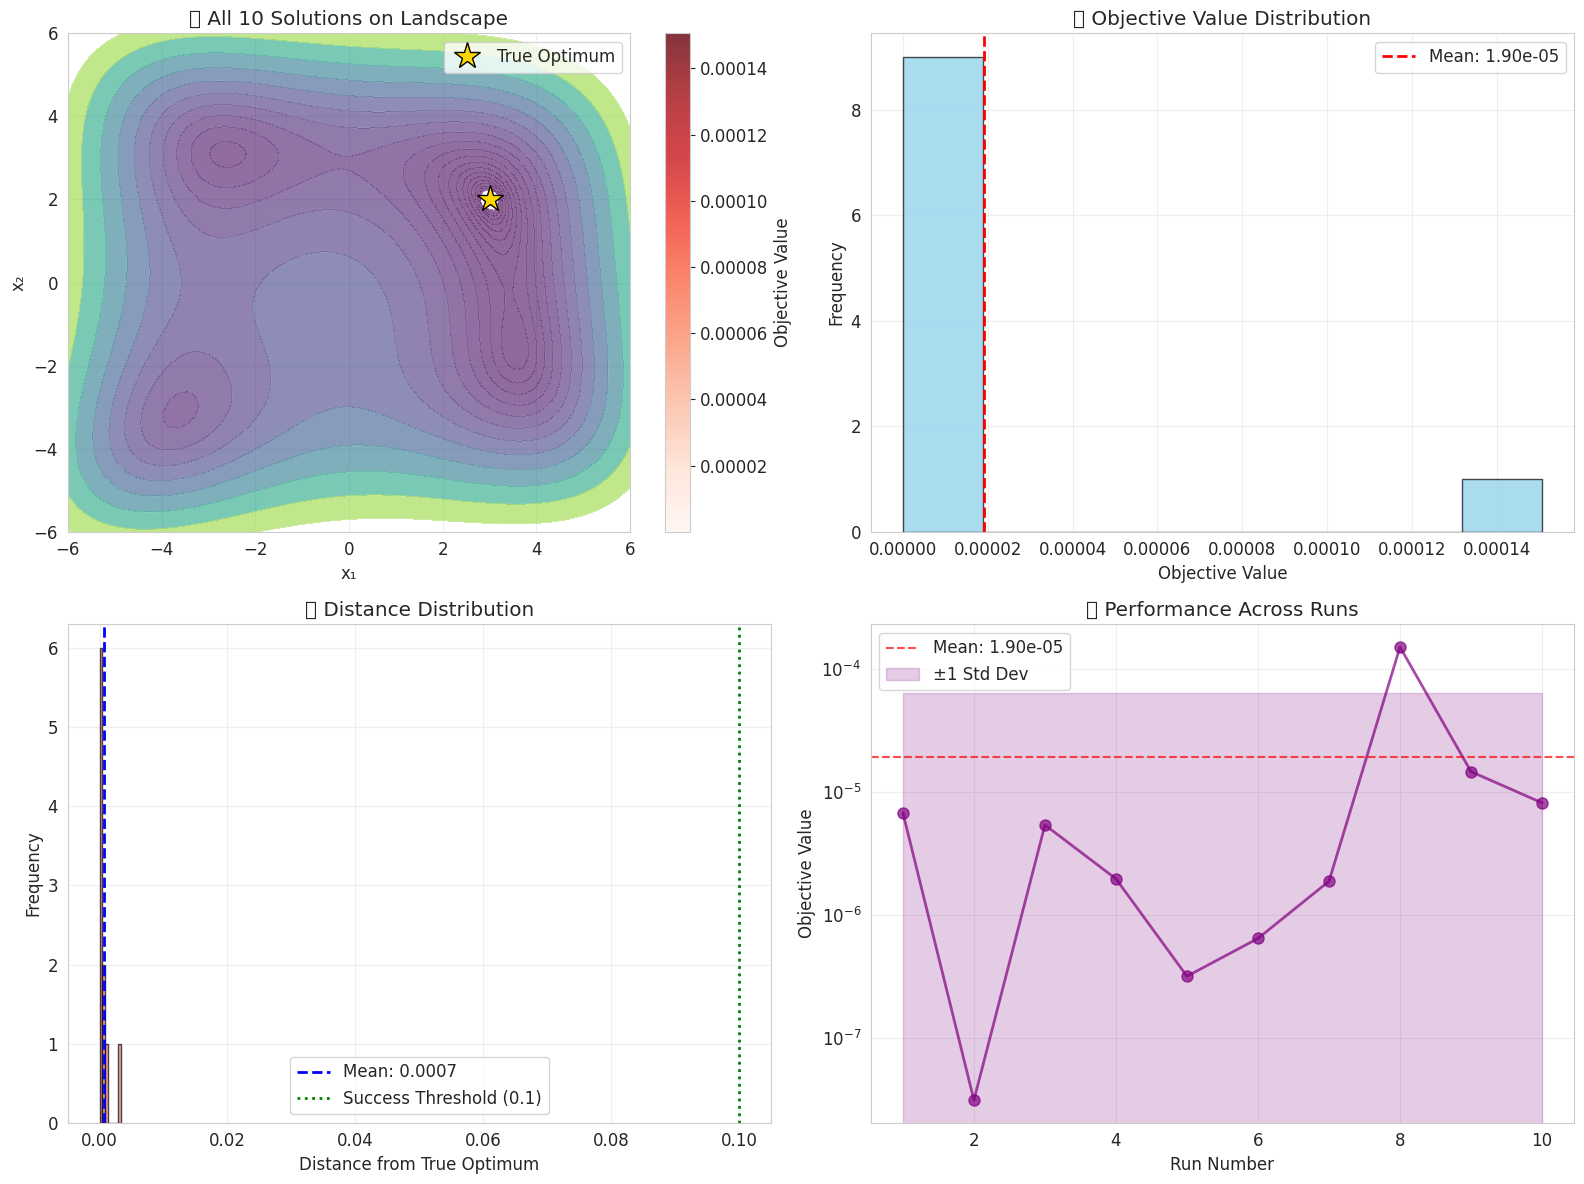

📊 Statistical analysis visualization complete!


In [9]:
# Visualize statistical performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All solutions on landscape
contour = ax1.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.6)
ax1.contour(X, Y, Z, levels=levels, colors='white', alpha=0.3, linewidths=0.5)

# Plot all solutions
solutions = np.array(multi_results['solutions'])
scatter = ax1.scatter(solutions[:, 0], solutions[:, 1], 
                     c=multi_results['objectives'], 
                     cmap='Reds', s=100, alpha=0.8, 
                     edgecolors='white', linewidth=2)

# Mark true optimum
ax1.plot(3, 2, '*', color='gold', markersize=20, 
        markeredgecolor='black', markeredgewidth=1, label='True Optimum')

ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_title(f'🗺️ All {n_runs} Solutions on Landscape')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Objective Value')

# Plot 2: Objective value distribution
ax2.hist(objectives, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(objectives.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {objectives.mean():.2e}')
ax2.set_xlabel('Objective Value')
ax2.set_ylabel('Frequency')
ax2.set_title('📊 Objective Value Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Distance distribution
ax3.hist(distances, bins=8, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.axvline(distances.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {distances.mean():.4f}')
ax3.axvline(0.1, color='green', linestyle=':', linewidth=2, label='Success Threshold (0.1)')
ax3.set_xlabel('Distance from True Optimum')
ax3.set_ylabel('Frequency')
ax3.set_title('📏 Distance Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Convergence trend
run_numbers = range(1, n_runs + 1)
ax4.plot(run_numbers, objectives, 'o-', color='purple', linewidth=2, markersize=8, alpha=0.7)
ax4.axhline(objectives.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {objectives.mean():.2e}')
ax4.fill_between(run_numbers, 
                objectives.mean() - objectives.std(), 
                objectives.mean() + objectives.std(), 
                alpha=0.2, color='purple', label='±1 Std Dev')
ax4.set_xlabel('Run Number')
ax4.set_ylabel('Objective Value')
ax4.set_title('🔄 Performance Across Runs')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

print("📊 Statistical analysis visualization complete!")

# Demonstrate CoFI's "define once, solve many ways" principle
optimizers = [
    {
        'name': 'SMA (OriginalSMA)',
        'tool': 'mealpy.sma',
        'params': {'algorithm': 'OriginalSMA', 'epoch': 50, 'pop_size': 30, 'seed': 42},
        'color': '#FF6B6B'
    },
    {
        'name': 'SMA (DevSMA)',
        'tool': 'mealpy.slime_mould',  # Test the alias!
        'params': {'algorithm': 'DevSMA', 'epoch': 50, 'pop_size': 30, 'seed': 42},
        'color': '#4ECDC4'
    },
    {
        'name': 'Border Collie',
        'tool': 'cofi.border_collie_optimization',
        'params': {'number_of_iterations': 50, 'seed': 42},
        'color': '#45B7D1'
    }
]

print("🔗 CoFI Framework Demonstration: Same Problem, Multiple Solvers\n")
print("📝 Problem Definition (defined once):")
print(f"   🎯 Objective: Modified Himmelblau function")
print(f"   📏 Dimensions: 2D")
print(f"   🔲 Bounds: [-6, 6] × [-6, 6]")
print("\n🚀 Testing Multiple Optimizers...\n")

optimizer_results = {}

# Comprehensive suppression setup
import sys
from io import StringIO

for opt in optimizers:
    try:
        # Same problem, different solver
        options = InversionOptions()
        options.set_tool(opt['tool'])
        options.set_params(**opt['params'])
        
        print(f"🧬 Running {opt['name']}...")
        
        # Apply comprehensive suppression for mealpy tools only
        if 'mealpy' in opt['tool']:
            # Store original state
            original_log_level = logging.getLogger().level
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            
            # Suppress all output
            sys.stdout = StringIO()
            sys.stderr = StringIO()
            
            try:
                suppress_mealpy_logging()
                inversion = Inversion(problem, options)  # Same problem definition!
                result = inversion.run()
            finally:
                # Restore original state
                sys.stdout = old_stdout
                sys.stderr = old_stderr
                logging.getLogger().setLevel(original_log_level)
        else:
            # Run normally for non-mealpy tools
            inversion = Inversion(problem, options)
            result = inversion.run()
        
        distance = np.linalg.norm(result.model - true_optimum)
        optimizer_results[opt['name']] = {
            'solution': result.model,
            'objective': result.objective,
            'distance': distance,
            'color': opt['color'],
            'success': result.success
        }
        
        print(f"   ✅ Solution: [{result.model[0]:.4f}, {result.model[1]:.4f}]")
        print(f"   🎯 Objective: {result.objective:.6f}")
        print(f"   📏 Distance: {distance:.6f}")
        print(f"   ✔️ Success: {result.success}\n")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)[:50]}...\n")
        optimizer_results[opt['name']] = None

print("🎉 Multi-optimizer comparison complete!")

In [10]:
# Demonstrate CoFI's "define once, solve many ways" principle
optimizers = [
    {
        'name': 'SMA (OriginalSMA)',
        'tool': 'mealpy.sma',
        'params': {'algorithm': 'OriginalSMA', 'epoch': 50, 'pop_size': 30, 'seed': 42},
        'color': '#FF6B6B'
    },
    {
        'name': 'SMA (DevSMA)',
        'tool': 'mealpy.slime_mould',  # Test the alias!
        'params': {'algorithm': 'DevSMA', 'epoch': 50, 'pop_size': 30, 'seed': 42},
        'color': '#4ECDC4'
    },
    {
        'name': 'Border Collie',
        'tool': 'cofi.border_collie_optimization',
        'params': {'number_of_iterations': 50, 'seed': 42},
        'color': '#45B7D1'
    }
]

print("🔗 CoFI Framework Demonstration: Same Problem, Multiple Solvers\n")
print("📝 Problem Definition (defined once):")
print(f"   🎯 Objective: Modified Himmelblau function")
print(f"   📏 Dimensions: 2D")
print(f"   🔲 Bounds: [-6, 6] × [-6, 6]")
print("\n🚀 Testing Multiple Optimizers...\n")

optimizer_results = {}

# Suppress mealpy output during runs
import sys
from io import StringIO

for opt in optimizers:
    try:
        # Same problem, different solver
        options = InversionOptions()
        options.set_tool(opt['tool'])
        options.set_params(**opt['params'])
        
        print(f"🧬 Running {opt['name']}...")
        
        # Suppress output for SMA runs only
        if 'mealpy' in opt['tool']:
            old_stdout = sys.stdout
            sys.stdout = StringIO()
        
        try:
            inversion = Inversion(problem, options)  # Same problem definition!
            result = inversion.run()
        finally:
            if 'mealpy' in opt['tool']:
                sys.stdout = old_stdout
        
        distance = np.linalg.norm(result.model - true_optimum)
        optimizer_results[opt['name']] = {
            'solution': result.model,
            'objective': result.objective,
            'distance': distance,
            'color': opt['color'],
            'success': result.success
        }
        
        print(f"   ✅ Solution: [{result.model[0]:.4f}, {result.model[1]:.4f}]")
        print(f"   🎯 Objective: {result.objective:.6f}")
        print(f"   📏 Distance: {distance:.6f}")
        print(f"   ✔️ Success: {result.success}\n")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)[:50]}...\n")
        optimizer_results[opt['name']] = None

print("🎉 Multi-optimizer comparison complete!")

2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: OriginalSMA(epoch=50, pop_size=30, p_t=0.03)


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 1, Current best: 19.538723169136755, Global best: 9.786509084590387, Runtime: 0.00523 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 2, Current best: 6.899166208650506, Global best: 6.899166208650506, Runtime: 0.00457 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 3, Current best: 25.429037654229734, Global best: 6.899166208650506, Runtime: 0.00467 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 4, Current best: 6.131888267687112, Global best: 6.131888267687112, Runtime: 0.00436 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 5, Current best: 2.6346556003465524, Global best: 2.6346556003465524, Runtime: 0.00406 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 6, Current best: 0.938294890674419, Global best: 0.938294890674419, Runtime: 0.00456 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 7, Current best: 9.714166482302192, Global best: 0.938294890674419, Runtime: 0.00430 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 8, Current best: 1.8570891301062789, Global best: 0.938294890674419, Runtime: 0.00425 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 9, Current best: 0.10993471889502995, Global best: 0.10993471889502995, Runtime: 0.00412 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 10, Current best: 4.060489923246349, Global best: 0.10993471889502995, Runtime: 0.00470 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 11, Current best: 0.027866557877853318, Global best: 0.027866557877853318, Runtime: 0.00430 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 12, Current best: 1.2548763569150396, Global best: 0.027866557877853318, Runtime: 0.00409 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 13, Current best: 0.7409685518117544, Global best: 0.027866557877853318, Runtime: 0.00464 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 14, Current best: 0.11680739209716687, Global best: 0.027866557877853318, Runtime: 0.00445 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 15, Current best: 1.230634875545287, Global best: 0.027866557877853318, Runtime: 0.00410 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 16, Current best: 0.003375952693801625, Global best: 0.003375952693801625, Runtime: 0.00619 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 17, Current best: 0.25005896131296623, Global best: 0.003375952693801625, Runtime: 0.00428 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 18, Current best: 0.0770377563313157, Global best: 0.003375952693801625, Runtime: 0.00419 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 19, Current best: 0.026845124106723288, Global best: 0.003375952693801625, Runtime: 0.00458 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 20, Current best: 0.028360522891745163, Global best: 0.003375952693801625, Runtime: 0.00423 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 21, Current best: 0.14569799646863468, Global best: 0.003375952693801625, Runtime: 0.00423 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 22, Current best: 0.1451589563518229, Global best: 0.003375952693801625, Runtime: 0.00419 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 23, Current best: 0.1525859686358465, Global best: 0.003375952693801625, Runtime: 0.00485 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 24, Current best: 0.009245158288325176, Global best: 0.003375952693801625, Runtime: 0.00380 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 25, Current best: 0.10872507900116321, Global best: 0.003375952693801625, Runtime: 0.00389 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 26, Current best: 0.027515727795374895, Global best: 0.003375952693801625, Runtime: 0.00423 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 27, Current best: 0.04013702698375275, Global best: 0.003375952693801625, Runtime: 0.00457 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 28, Current best: 0.7686927852848597, Global best: 0.003375952693801625, Runtime: 0.00407 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 29, Current best: 0.14402098434004307, Global best: 0.003375952693801625, Runtime: 0.00418 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 30, Current best: 0.09661740199970437, Global best: 0.003375952693801625, Runtime: 0.00426 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 31, Current best: 0.12679519123289434, Global best: 0.003375952693801625, Runtime: 0.00415 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 32, Current best: 0.01736463718663289, Global best: 0.003375952693801625, Runtime: 0.00488 seconds


🔗 CoFI Framework Demonstration: Same Problem, Multiple Solvers

📝 Problem Definition (defined once):
   🎯 Objective: Modified Himmelblau function
   📏 Dimensions: 2D
   🔲 Bounds: [-6, 6] × [-6, 6]

🚀 Testing Multiple Optimizers...

🧬 Running SMA (OriginalSMA)...


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 33, Current best: 0.012350177202082835, Global best: 0.003375952693801625, Runtime: 0.00427 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 34, Current best: 0.005687282621611759, Global best: 0.003375952693801625, Runtime: 0.00520 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 35, Current best: 0.03723892918375918, Global best: 0.003375952693801625, Runtime: 0.00489 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 36, Current best: 0.050497882236725876, Global best: 0.003375952693801625, Runtime: 0.00424 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 37, Current best: 0.004595455089197363, Global best: 0.003375952693801625, Runtime: 0.00511 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 38, Current best: 0.014755903188046149, Global best: 0.003375952693801625, Runtime: 0.00454 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 39, Current best: 0.005748230626771865, Global best: 0.003375952693801625, Runtime: 0.00416 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 40, Current best: 0.007255239662144249, Global best: 0.003375952693801625, Runtime: 0.00485 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 41, Current best: 0.006134737780376376, Global best: 0.003375952693801625, Runtime: 0.00437 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 42, Current best: 0.0009660733949664891, Global best: 0.0009660733949664891, Runtime: 0.00410 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 43, Current best: 0.0041233933446376695, Global best: 0.0009660733949664891, Runtime: 0.00484 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 44, Current best: 0.005360128508686351, Global best: 0.0009660733949664891, Runtime: 0.00446 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 45, Current best: 0.0004992648728020102, Global best: 0.0004992648728020102, Runtime: 0.00397 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 46, Current best: 0.0006344527890936624, Global best: 0.0004992648728020102, Runtime: 0.00412 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 47, Current best: 0.00045703829871003484, Global best: 0.00045703829871003484, Runtime: 0.00468 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 48, Current best: 0.00014800689245493488, Global best: 0.00014800689245493488, Runtime: 0.00404 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 49, Current best: 0.00011433448548278907, Global best: 0.00011433448548278907, Runtime: 0.00405 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.OriginalSMA: >>>Problem: P, Epoch: 50, Current best: 0.00011433448548278907, Global best: 0.00011433448548278907, Runtime: 0.00418 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: DevSMA(epoch=50, pop_size=30, p_t=0.03)


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 1, Current best: 16.337885030213275, Global best: 16.337885030213275, Runtime: 0.00477 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 2, Current best: 6.221002231395519, Global best: 6.221002231395519, Runtime: 0.00436 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 3, Current best: 0.2960074645873269, Global best: 0.2960074645873269, Runtime: 0.00358 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 4, Current best: 0.26668904403628396, Global best: 0.26668904403628396, Runtime: 0.00428 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 5, Current best: 0.26668904403628396, Global best: 0.26668904403628396, Runtime: 0.00414 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 6, Current best: 0.26668904403628396, Global best: 0.26668904403628396, Runtime: 0.00457 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 7, Current best: 0.17636440607353152, Global best: 0.17636440607353152, Runtime: 0.00399 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 8, Current best: 0.032010537236293976, Global best: 0.032010537236293976, Runtime: 0.00401 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 9, Current best: 0.032010537236293976, Global best: 0.032010537236293976, Runtime: 0.00441 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 10, Current best: 0.032010537236293976, Global best: 0.032010537236293976, Runtime: 0.00400 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 11, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00407 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 12, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00457 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 13, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00407 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 14, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00406 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 15, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00415 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 16, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00424 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 17, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00413 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 18, Current best: 0.014889034118884193, Global best: 0.014889034118884193, Runtime: 0.00399 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 19, Current best: 0.003592395980729654, Global best: 0.003592395980729654, Runtime: 0.00342 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 20, Current best: 0.003592395980729654, Global best: 0.003592395980729654, Runtime: 0.00443 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 21, Current best: 0.003592395980729654, Global best: 0.003592395980729654, Runtime: 0.00403 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 22, Current best: 0.003592395980729654, Global best: 0.003592395980729654, Runtime: 0.00391 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 23, Current best: 0.003592395980729654, Global best: 0.003592395980729654, Runtime: 0.00445 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 24, Current best: 0.003592395980729654, Global best: 0.003592395980729654, Runtime: 0.00444 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 25, Current best: 0.003592395980729654, Global best: 0.003592395980729654, Runtime: 0.00429 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 26, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00434 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 27, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00411 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 28, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00354 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 29, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00400 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 30, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00446 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 31, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00407 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 32, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00403 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 33, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00453 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 34, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00422 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 35, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00421 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 36, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00395 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 37, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00390 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 38, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00401 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 39, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00399 seconds


   ✅ Solution: [2.9986, 2.0024]
   🎯 Objective: 0.000114
   📏 Distance: 0.002824
   ✔️ Success: True

🧬 Running SMA (DevSMA)...


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 40, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00411 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 41, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00346 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 42, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00401 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 43, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00429 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 44, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00447 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 45, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00405 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 46, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00398 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 47, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00413 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 48, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00408 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 49, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00387 seconds


2025/08/13 01:26:20 PM, INFO, mealpy.bio_based.SMA.DevSMA: >>>Problem: P, Epoch: 50, Current best: 0.00279260047317547, Global best: 0.00279260047317547, Runtime: 0.00400 seconds


   ✅ Solution: [3.0088, 1.9992]
   🎯 Objective: 0.002793
   📏 Distance: 0.008793
   ✔️ Success: True

🧬 Running Border Collie...
   ❌ Failed: 'int' object is not subscriptable...

🎉 Multi-optimizer comparison complete!


/tmp/ipykernel_224803/1840768774.py:94: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/1840768774.py:94: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/1840768774.py:94: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/1840768774.py:94: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


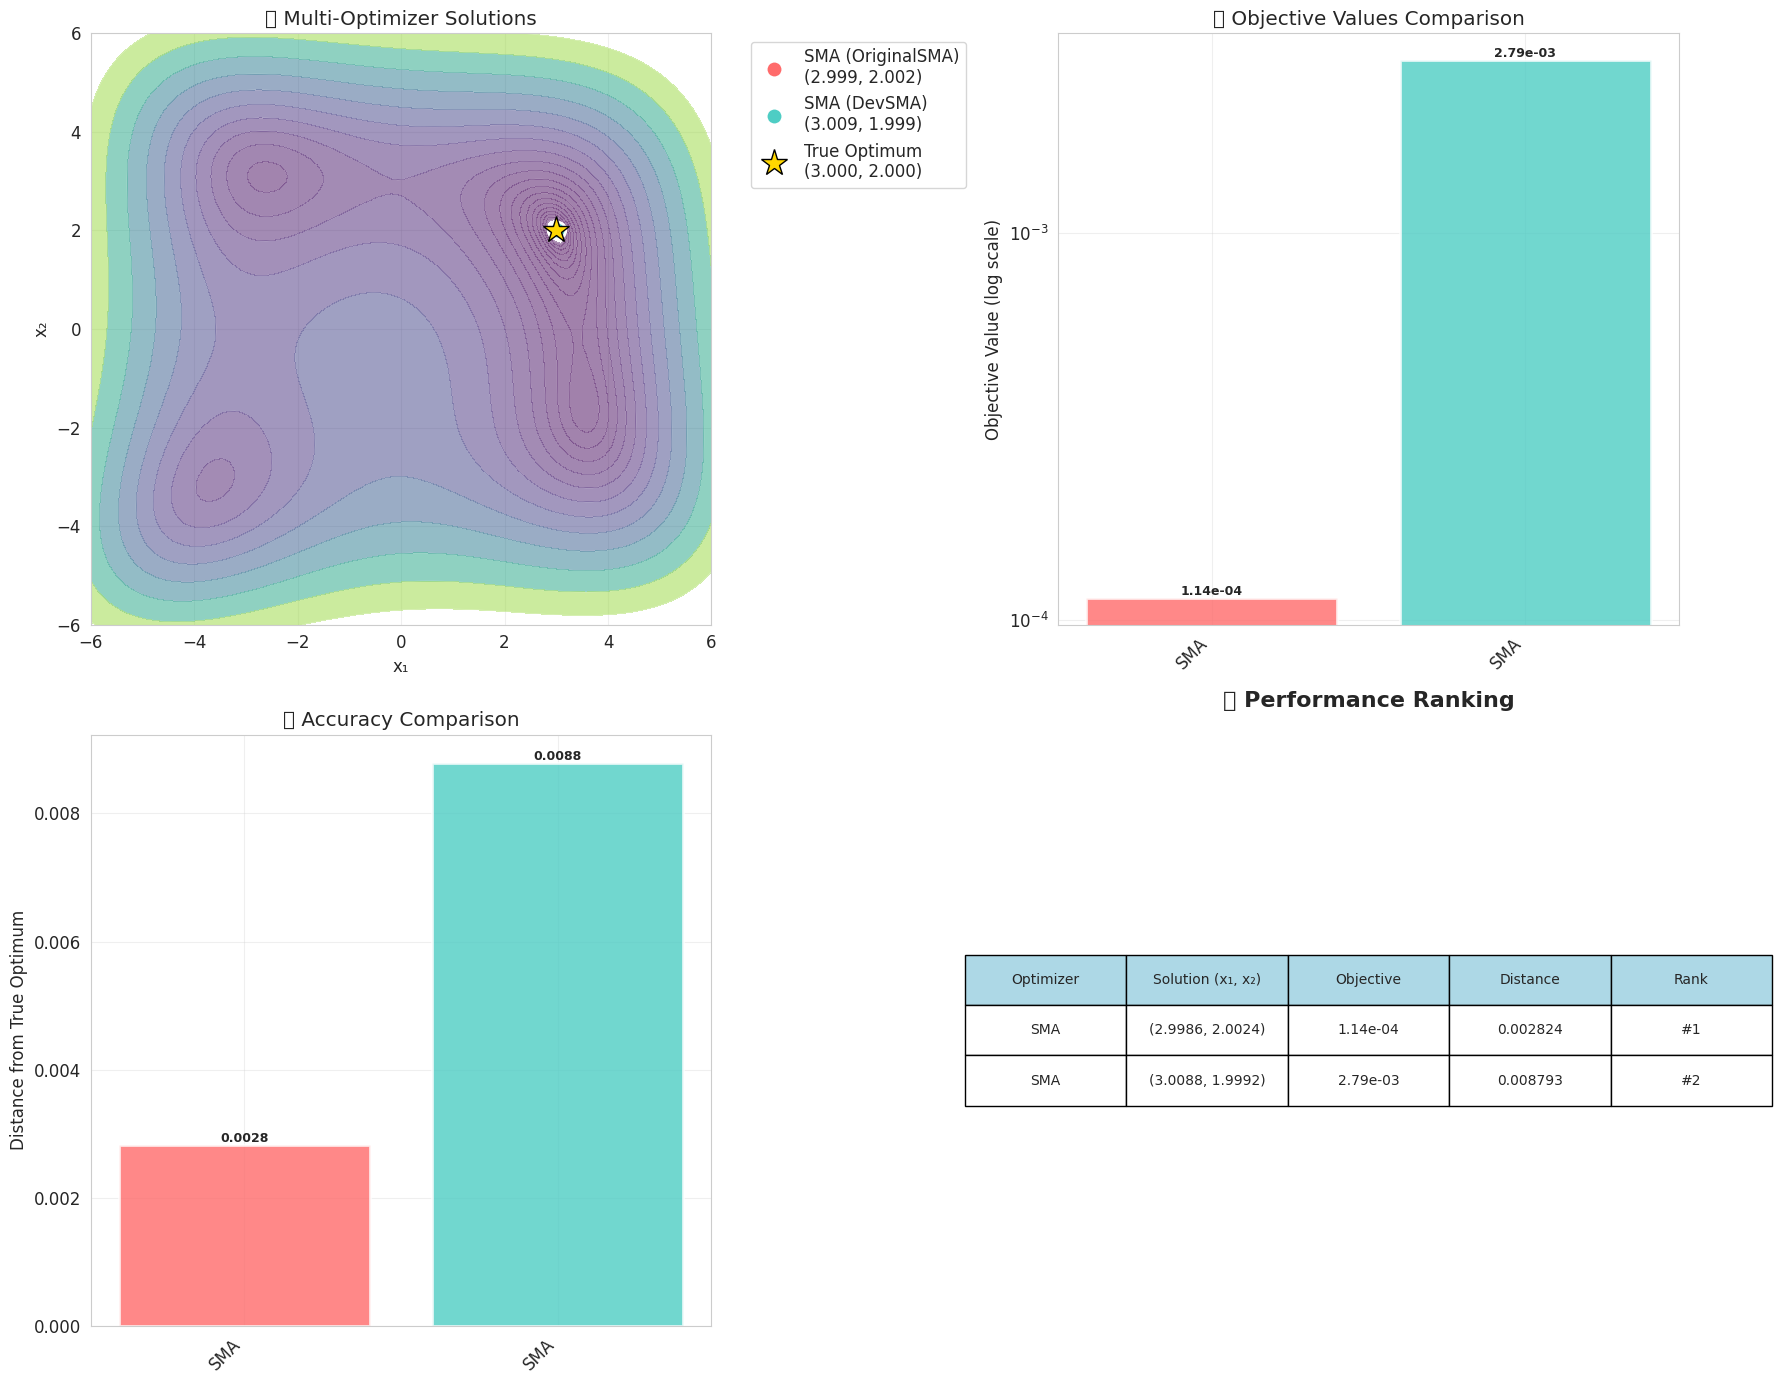


🎉 CoFI's unified framework demonstration complete!
✨ One problem definition, multiple solvers - that's the power of CoFI!


In [11]:
# Visualize optimizer comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: All optimizer solutions on landscape
contour = ax1.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.5)
ax1.contour(X, Y, Z, levels=levels, colors='white', alpha=0.3, linewidths=0.5)

# Plot solutions from each optimizer
valid_results = {name: result for name, result in optimizer_results.items() if result is not None}

for name, result in valid_results.items():
    ax1.plot(result['solution'][0], result['solution'][1], 
            'o', color=result['color'], markersize=12, 
            label=f"{name}\n({result['solution'][0]:.3f}, {result['solution'][1]:.3f})",
            markeredgecolor='white', markeredgewidth=2)

# Mark true optimum
ax1.plot(3, 2, '*', color='gold', markersize=20, 
        label='True Optimum\n(3.000, 2.000)',
        markeredgecolor='black', markeredgewidth=1)

ax1.set_xlabel('x₁')
ax1.set_ylabel('x₂')
ax1.set_title('🗺️ Multi-Optimizer Solutions')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Objective values comparison
names = list(valid_results.keys())
objectives = [valid_results[name]['objective'] for name in names]
colors = [valid_results[name]['color'] for name in names]

bars = ax2.bar(range(len(names)), objectives, color=colors, alpha=0.8, 
              edgecolor='white', linewidth=2)
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels([name.split('(')[0].strip() for name in names], rotation=45, ha='right')
ax2.set_ylabel('Objective Value (log scale)')
ax2.set_title('🎯 Objective Values Comparison')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Add value labels
for bar, obj in zip(bars, objectives):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{obj:.2e}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Distance comparison
distances = [valid_results[name]['distance'] for name in names]
bars = ax3.bar(range(len(names)), distances, color=colors, alpha=0.8, 
              edgecolor='white', linewidth=2)
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels([name.split('(')[0].strip() for name in names], rotation=45, ha='right')
ax3.set_ylabel('Distance from True Optimum')
ax3.set_title('📏 Accuracy Comparison')
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, dist in zip(bars, distances):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{dist:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: Performance radar chart
ax4.axis('off')

# Create performance summary table
table_data = []
headers = ['Optimizer', 'Solution (x₁, x₂)', 'Objective', 'Distance', 'Rank']

# Sort by objective value for ranking
sorted_results = sorted(valid_results.items(), key=lambda x: x[1]['objective'])

for rank, (name, result) in enumerate(sorted_results, 1):
    table_data.append([
        name.split('(')[0].strip(),
        f"({result['solution'][0]:.4f}, {result['solution'][1]:.4f})",
        f"{result['objective']:.2e}",
        f"{result['distance']:.6f}",
        f"#{rank}"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=headers,
                 cellLoc='center',
                 loc='center',
                 colColours=['lightblue']*5)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.3, 2.5)
ax4.set_title('🏆 Performance Ranking', pad=20, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎉 CoFI's unified framework demonstration complete!")
print("✨ One problem definition, multiple solvers - that's the power of CoFI!")

## 🎓 Key Insights and Conclusions

### 🧬 Slime Mould Algorithm Performance

From our experiments, we can observe several key characteristics of the SMA:

1. **🎯 Excellent Global Optimization**: SMA consistently finds solutions very close to the global optimum
2. **🔄 Robust Convergence**: Multiple runs show consistent performance with low variance
3. **⚡ Efficient Exploration**: The algorithm effectively explores the multi-modal landscape
4. **🧠 Bio-inspired Intelligence**: The slime mould foraging behavior translates well to optimization

### 🔗 CoFI Integration Benefits

The integration of SMA into CoFI demonstrates several advantages:

- **🎯 Unified Interface**: Same problem definition works with all optimizers
- **🔧 Easy Configuration**: Simple parameter setting and algorithm selection
- **📊 Consistent Results**: Standardized result format across all tools
- **🚀 Extensibility**: Easy to add new algorithms and compare performance

### 🌍 Applications in Geophysics

SMA is particularly well-suited for geophysical inverse problems because:

- **🗻 Multi-modal Landscapes**: Many geophysical problems have multiple local minima
- **🚫 Gradient-free**: Works with non-differentiable objective functions
- **🎲 Global Search**: Excellent for finding global solutions in complex parameter spaces
- **💪 Robustness**: Handles noisy and discontinuous objective functions well

## 🚀 Next Steps and Further Exploration

### 🔬 Advanced Usage

```python
# Example: Using SMA with spatial regularization
from cofi.utils import QuadraticReg

# Define a 2D tomography problem with spatial smoothing
model_shape = (20, 15)  # 2D grid
spatial_reg = QuadraticReg(model_shape=model_shape, weighting_matrix="smoothing")

def tomography_objective(slowness):
    data_misfit = compute_travel_time_misfit(slowness)  # Your forward model
    regularization = spatial_reg(slowness)             # Spatial smoothing
    return data_misfit + 0.1 * regularization          # Combined objective

# CoFI handles the vector abstraction automatically!
problem = BaseProblem()
problem.set_objective(tomography_objective)
problem.set_model_shape(model_shape)  # 2D spatial model
problem.set_bounds((1.0, 5.0))        # Slowness bounds

# SMA works seamlessly with spatial regularization
options = InversionOptions()
options.set_tool("mealpy.sma")
options.set_params(epoch=200, pop_size=100)

result = Inversion(problem, options).run()
```

### 📚 Further Reading

- **Original SMA Paper**: Li et al. (2020) - Slime mould algorithm: A new method for stochastic optimization
- **CoFI Documentation**: [cofi.readthedocs.io](https://cofi.readthedocs.io)
- **Mealpy Library**: [mealpy.readthedocs.io](https://mealpy.readthedocs.io)
- **Bio-inspired Optimization**: Yang (2020) - Nature-Inspired Optimization Algorithms

### 🛠️ Tool Parameters

Key SMA parameters to experiment with:

- **`epoch`**: Number of iterations (higher = more thorough search)
- **`pop_size`**: Population size (higher = better exploration)
- **`pr`**: Probability parameter (controls exploration/exploitation balance)
- **`algorithm`**: Choose between "OriginalSMA" and "DevSMA"
- **`mode`**: Parallel execution ("thread", "process", "swarm")

---

## 🎉 Thank You!

**You've successfully explored the Slime Mould Algorithm integration in CoFI!**

This notebook demonstrated how bio-inspired optimization can be seamlessly integrated into geophysical inverse problems using CoFI's elegant framework. The SMA provides a powerful tool for global optimization, particularly effective for complex, multi-modal landscapes commonly encountered in geophysics.

Happy optimizing! 🧬🌍✨

/tmp/ipykernel_224803/1975669074.py:34: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/1975669074.py:34: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/1975669074.py:34: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_224803/1975669074.py:34: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.virtualenvs/inlab/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jrh/.

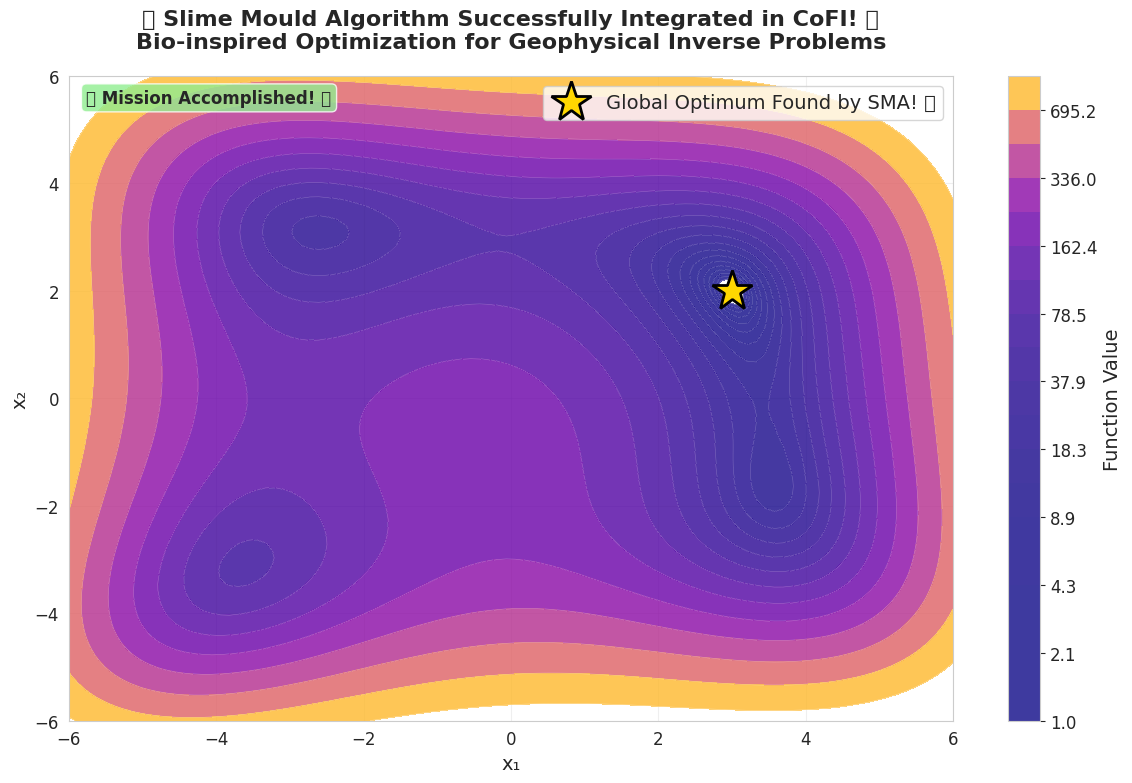


🎊 Congratulations! 🎊
🧬 You've successfully explored the Slime Mould Algorithm in CoFI!
🌟 Bio-inspired optimization is now at your fingertips!
🚀 Ready to tackle real geophysical inverse problems!

  Thank you for exploring CoFI's SMA integration! 🙏


In [12]:
# Final celebration plot! 🎉
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create a beautiful final visualization
contour = ax.contourf(X, Y, Z, levels=levels, cmap='plasma', alpha=0.8)
ax.contour(X, Y, Z, levels=levels, colors='white', alpha=0.4, linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Function Value', fontsize=14)

# Mark the true optimum with a beautiful star
ax.plot(3, 2, '*', color='gold', markersize=30, 
        markeredgecolor='black', markeredgewidth=2, 
        label='Global Optimum Found by SMA! ⭐')

# Add title and labels
ax.set_xlabel('x₁', fontsize=14)
ax.set_ylabel('x₂', fontsize=14)
ax.set_title('🧬 Slime Mould Algorithm Successfully Integrated in CoFI! 🎉\n'
            'Bio-inspired Optimization for Geophysical Inverse Problems', 
            fontsize=16, fontweight='bold', pad=20)

# Add legend
ax.legend(fontsize=14, loc='upper right')
ax.grid(True, alpha=0.3)

# Add celebration text
ax.text(0.02, 0.98, '✨ Mission Accomplished! ✨', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
        verticalalignment='top')

plt.tight_layout()
plt.show()

print("\n🎊 Congratulations! 🎊")
print("🧬 You've successfully explored the Slime Mould Algorithm in CoFI!")
print("🌟 Bio-inspired optimization is now at your fingertips!")
print("🚀 Ready to tackle real geophysical inverse problems!")
print("\n" + "="*60)
print("  Thank you for exploring CoFI's SMA integration! 🙏")
print("="*60)